In [1]:
%matplotlib  inline
import pandas as pd
from datetime import datetime
import quandl
import xgboost
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.cross_validation import *
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing as prep
import seaborn as sns
import sklearn.model_selection as ms
from sklearn.metrics import mean_squared_error
from math import sqrt
from scipy.stats import pearsonr
import datetime
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
yf.pdr_override()
from scipy import poly1d
from pykalman import KalmanFilter

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# function definitions

In [2]:
# All helper functions go here
def supres(ltp, n):
    """
    This function takes a numpy array of last traded price
    and returns a list of support and resistance levels 
    respectively. n is the number of entries to be scanned.
    """
    from scipy.signal import savgol_filter as smooth

    #converting n to a nearest even number
    if n%2 != 0:
        n += 1
    ltp=np.ravel(ltp)
    n_ltp = ltp.shape[0]

    # smoothening the curve
    ltp_s = smooth(ltp, (n+1), 3) 

    #taking a simple derivative
    ltp_d = np.zeros(n_ltp)
    ltp_d[1:] = np.subtract(ltp_s[1:], ltp_s[:-1])
 
    resistance = []
    support = []
    
    for i in range(n_ltp - n):
        arr_sl = ltp_d[i:(i+n)]
        first = arr_sl[:int((n/2))] #first half
        last = arr_sl[int((n/2)):] #second half
        
        r_1 = np.sum(first > 0)
        r_2 = np.sum(last < 0)

        s_1 = np.sum(first < 0)
        s_2 = np.sum(last > 0)

        #local maxima detection
        if (r_1 == int((n/2))) and (r_2 == int((n/2))): 
            resistance.append(ltp[i+int(((n/2))-1)])

        #local minima detection
        if (s_1 == int((n/2))) and (s_2 == int((n/2))): 
            support.append(ltp[i+int(((n/2))-1)])

    return support, resistance
import scipy.ndimage as ndimage

def local_extreme(array, min_distance = 20, periodic=False, edges_allowed=True,find_max=True): 
    """Find all local maxima of the array, separated by at least min_distance."""
    array = np.asarray(array)
    cval = 0 
    if periodic: 
        mode = 'wrap' 
    elif edges_allowed: 
        mode = 'nearest' 
    else: 
        mode = 'constant' 
    cval = array.max()+1 
    if find_max:
        max_points = array == ndimage.maximum_filter(array, 1+2*min_distance, mode=mode, cval=cval) 
    else:
        max_points = array == ndimage.minimum_filter(array, 1+2*min_distance, mode=mode, cval=cval) 
        
    return [indices[max_points] for indices in np.indices(array.shape)]

def extreme_significance(exArray, tolerance=0.02,signi_level=1):
    """Find Significance of extreme values within tolerance bound."""
    array = np.asarray(exArray)
    array = np.ravel(array)
    signifArr = np.zeros(len(array))
    d = {'data': array, 'sign': signifArr}
    result = pd.DataFrame(data=d).values
    print('len of x is: '+repr(len(result)))
    for i in range(len(result)):
        val = result[i,0]
        signif = 0
        for j in range(i+1,len(result)):
            if (result[j,0]>= val*(1-tolerance)) and  (array[j]<= val*(1+tolerance)):
                    signif = signif + 1
            result[i,1] = signif
            
    result = pd.DataFrame(data=result,columns=['ExtremeValue', 'Significance'])
    result = result[result.Significance>=signi_level]
    return result.sort_values(by=['Significance'],ascending=False)

def grouper(iterable, max_distance):
    """Group extremes by cluster based on absolute price distance."""
    # if Dataframe take first column
    if isinstance(signify,pd.core.frame.DataFrame):
        iterable = iterable.sort_values(by=iterable.columns[0]).iloc[:,0].values
    elif isinstance(signify,np.ndarray):
        iterable =np.sort(iterable)
    prev = None
    group = []
    for item in iterable:
        if not prev or item - prev <= max_distance:
            group.append(item)
        else:
            yield group
            group = [item]
        prev = item
    if group:
        yield group
def group_extremes(inp,max_distance):
    """Calculate centroid for each cluster of prices"""
    inp = dict(enumerate(grouper(inp,max_distance), 1))
    avgDict = {}
    for k,v in inp.items():
        # v is the list of items for dict row k
        avgDict[k] = sum(v)/ float(len(v))
    return list(avgDict.values())

def logReturns(df):
    """Calculate logReturns of price series"""
    log_ret = np.log(df) - np.log(df.shift(1))
    return log_ret

def tsi(close, r=25, s=13, fillna=True):
    """Calculate TSI Indicator of close price series"""
    m = close - close.shift(1)
    m1 = m.ewm(r).mean().ewm(s).mean()
    m2 = abs(m).ewm(r).mean().ewm(s).mean()
    tsi = m1/m2
    if fillna:
        tsi = tsi.fillna(0)
    return pd.Series(100*tsi, name='tsi')

def on_balance_volume(close, volume):
    """Calculate OBV Indicator of close price series and Volume"""
    df = pd.DataFrame([close, volume]).transpose()
    df['OBV'] = 0
    c1 = close < close.shift(1)
    c2 = close > close.shift(1)
    if c1.any():
        df.loc[c1, 'OBV'] = - volume
    if c2.any():
        df.loc[c2, 'OBV'] = volume
    return df['OBV']

def average_true_range(high, low, close, n=14, fillna=False):
    """Average True Range (ATR)
    The indicator provide an indication of the degree of price volatility.
    Strong moves, in either direction, are often accompanied by large ranges,
    or large True Ranges.
    http://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:average_true_range_atr
    Args:
        high(pandas.Series): dataset 'High' column.
        low(pandas.Series): dataset 'Low' column.
        close(pandas.Series): dataset 'Close' column.
        n(int): n period.
    Returns:
        pandas.Series: New feature generated.
    """
    cs = close.shift(1)
    tr = high.combine(cs, max) - low.combine(cs, min)
    tr = tr.ewm(n).mean()
    if fillna:
        tr = tr.fillna(0)
    return pd.Series(tr, name='atr')

def kst(close, r1=10, r2=15, r3=20, r4=30, n1=10, n2=10, n3=10, n4=15, nsig=9, fillna=True):
    """Calculate KST Indicator of close price series. See https://en.wikipedia.org/wiki/KST_oscillator"""
    rocma1 = (close / close.shift(r1) - 1).rolling(n1).mean()
    rocma2 = (close / close.shift(r2) - 1).rolling(n2).mean()
    rocma3 = (close / close.shift(r3) - 1).rolling(n3).mean()
    rocma4 = (close / close.shift(r4) - 1).rolling(n4).mean()
    kst = 100*(rocma1 + 2*rocma2 + 3*rocma3 + 4*rocma4)
    sig = kst.rolling(nsig).mean()
    if fillna:
        sig = sig.fillna(0)
    return pd.Series(sig, name='sig')

def find_nearest(array, value,findMax=True):
    """Find nearest value of extreme value"""
    array = np.sort(np.asarray(array))
    if findMax:
        array = array[array>=value]
    else:
        array = array[array<=value]
    if array.size > 0:
        idx = (np.abs(array - value)).argmin()
        return array[idx]
    else:
        return np.nan
    
def calc_extreme_distance(series,sup_array,res_array):
    if isinstance(series,pd.core.frame.DataFrame):
        series = np.ravel(series.values())
    elif isinstance(series,np.ndarray):
        series =np.ravel(series)
    sup_array = np.ravel(np.array(sup_array))
    res_array = np.ravel(np.array(res_array))
    dist_s = []
    dist_r = []
    #if not sup_array:
    #    print("test")
    #else:
    for i in range(len(series)):
        curr_value = series[i]
        nearest_sup = find_nearest(sup_array, curr_value,findMax=False)
        nearest_res = find_nearest(res_array, curr_value)
        if curr_value < nearest_sup:
            dist_s.append(np.nan)
        elif curr_value > nearest_res:
            dist_r.append(np.nan)
        else:
            dist_s.append(curr_value-nearest_sup)
            dist_r.append(nearest_res-curr_value)
    if dist_s and dist_r:
        return dist_s,dist_r
    
def r_score(y_true, y_pred, sample_weight=None, multioutput=None):
    r2 = r2_score(y_true, y_pred, sample_weight=sample_weight, multioutput=multioutput)
    r = (np.sign(r2)*np.sqrt(np.abs(r2)))
    if r <= -1:
        return -1
    else:
        return r
def calc_r_score (actual_and_test):
    r = []
    r.append(0)
    for i in range(1,len(actual_and_test)):
        ri = r_score(actual_and_test[0:i,0],actual_and_test[0:i,1])
        if ri <= -1:
            ri = 0
        r.append(ri)
    return r

# Data collection from Quandl and YahooFinance for daily data

In [3]:
quandl.ApiConfig.api_key = "xoemPs9s3Dtwf3aQxQ-3"
start="2010-01-02"

INTC = pdr.get_data_yahoo("INTC",start=start)
MSFT = pdr.get_data_yahoo("MSFT",start=start)
AMZN = pdr.get_data_yahoo("AMZN",start=start)
NVDA = pdr.get_data_yahoo("NVDA",start=start)
GOOG = pdr.get_data_yahoo("GOOG",start=start)
NFLX = pdr.get_data_yahoo("NFLX",start=start)
# macro data 
EUROSTOXX50 = pdr.get_data_yahoo("FEZ",start=start)
SNP500 = pdr.get_data_yahoo("^GSPC",start=start)
CONS_DESCRETE = pdr.get_data_yahoo("XLY",start=start)
SNP_TECH = pdr.get_data_yahoo("XLK",start=start)
NASDAQ_COMP = pdr.get_data_yahoo("^IXIC",start=start)
VIX = pdr.get_data_yahoo("^VIX",start=start)

# FRED & Treasury
yieldr = quandl.get("USTREASURY/REALYIELD", start_date=start, verify=False)
consumer_price_index = quandl.get("FRED/CPIAUCSL", start_date=start, verify=False)
gdpc = quandl.get("FRED/GDPC1", start_date=start, verify=False)
tnote_y10 = quandl.get("FRED/DGS10", start_date=start, verify=False)
financial_stress = quandl.get("FRED/STLFSI", start_date=start, verify=False)
effective_federal_fund_rate = quandl.get("FRED/FEDFUNDS", start_date=start, verify=False)

[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded


# Get extreme values based on nearest neighbour search and plot horizontal support and resistance lines

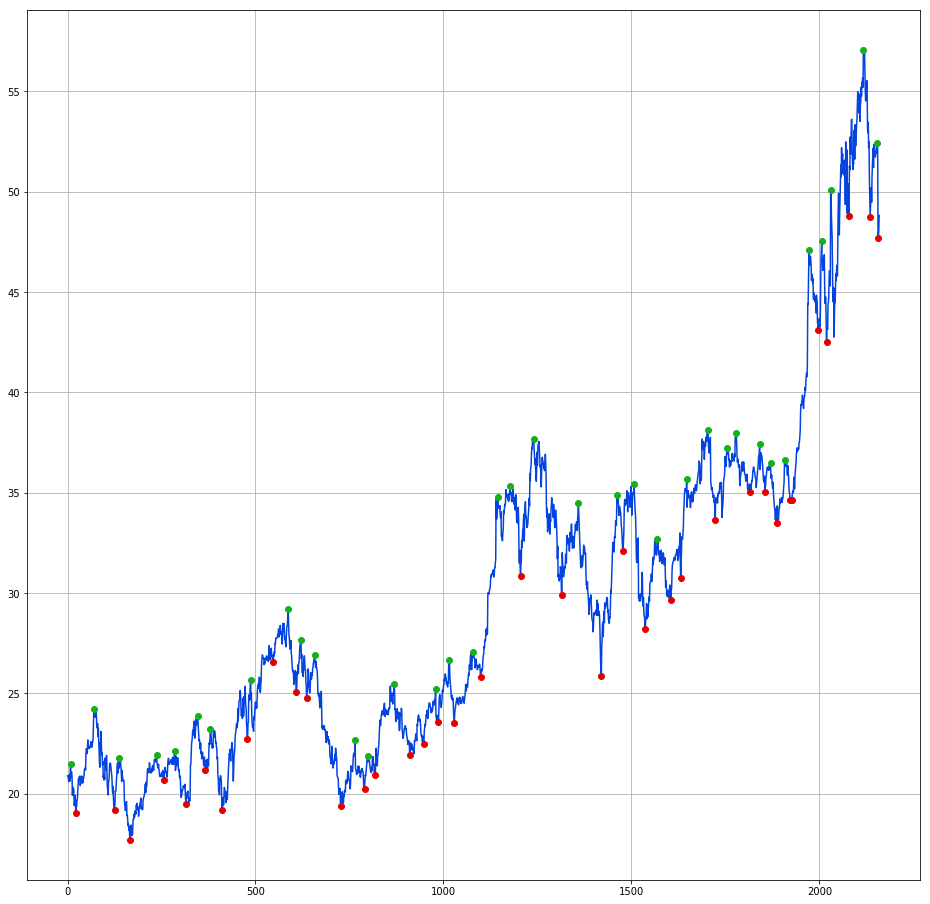

In [4]:
# Plots
cl=np.ravel(INTC[['Close']].values)
plt.rc("figure",figsize=(16,16))
plt.plot(cl,color='xkcd:blue',linestyle ='-')
mDistance = 20
plt.plot(np.ravel(local_extreme(cl,min_distance= mDistance,find_max=True)),
         np.ravel(cl[local_extreme(cl,min_distance= mDistance,find_max=True)]) ,color='xkcd:green',marker='o',linestyle ='')
plt.plot(np.ravel(local_extreme(cl,min_distance= mDistance,find_max=False)),
         np.ravel(cl[local_extreme(cl,min_distance= mDistance,find_max=False)]) ,color='xkcd:red',marker='o',linestyle ='')
plt.grid(True)

len of x is: 36


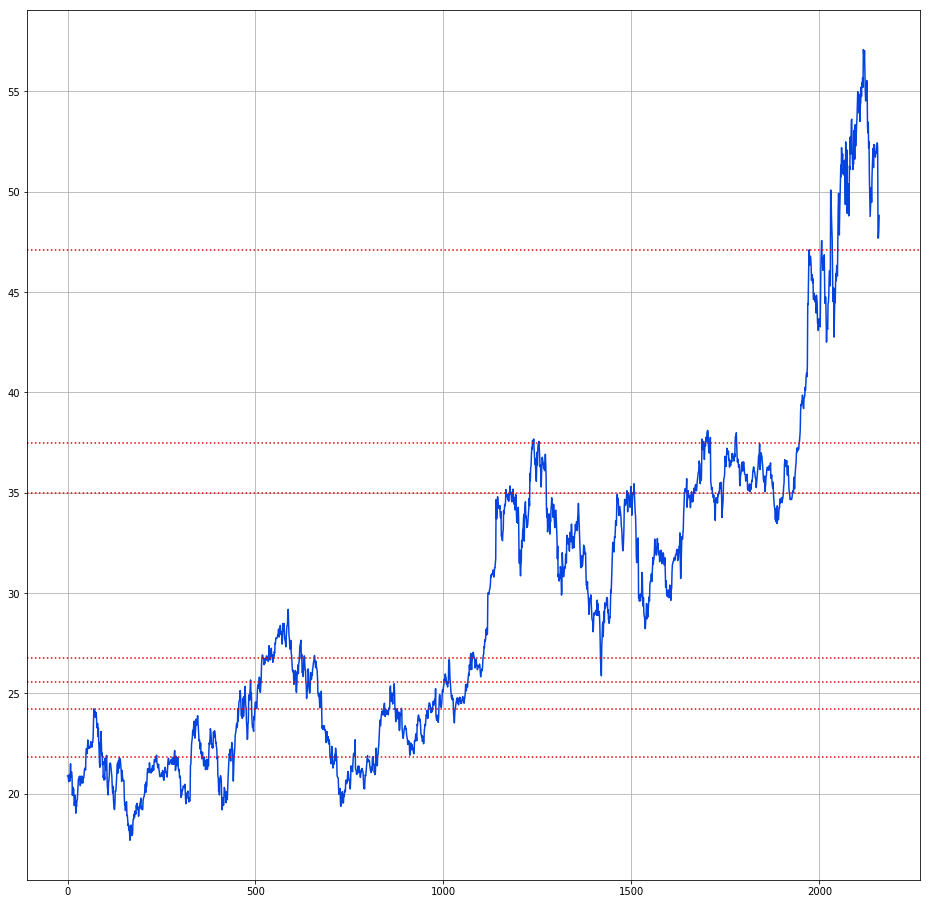

In [5]:
# Show horizontal resistance levels based on extreme points and significance
array = np.ravel(cl[local_extreme(cl,min_distance= mDistance,find_max=True)])
signify = extreme_significance(array, tolerance=0.02,signi_level=1)
extremes_res = group_extremes(signify,1)
plt.rc("figure",figsize=(16,16))
plt.plot(cl,color='xkcd:blue',linestyle ='-')
yval = np.ravel(extremes_res)
for x in yval:
    plt.axhline(y=x,color='xkcd:red',linestyle =':')
plt.grid(True)

len of x is: 37


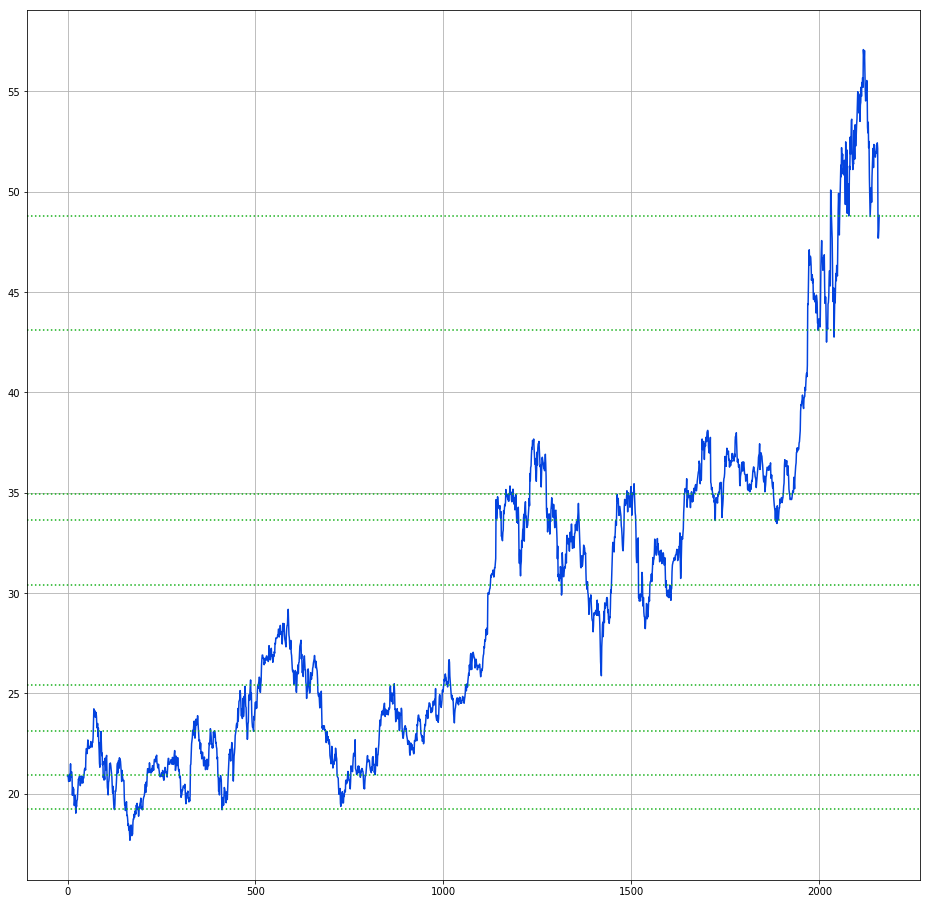

In [6]:
# Show horizontal support levels based on extreme points and significance
array = np.ravel(cl[local_extreme(cl,min_distance= mDistance,find_max=False)])
signify =extreme_significance(array, tolerance=0.02,signi_level=1)
extremes_sup = group_extremes(signify,1)
plt.rc("figure",figsize=(16,16))
plt.plot(cl,color='xkcd:blue',linestyle ='-')
yval = np.ravel(extremes_sup)
for x in yval:
    plt.axhline(y=x,color='xkcd:green',linestyle =':')
plt.grid(True)

# Calculate kalman filter estimate of mean

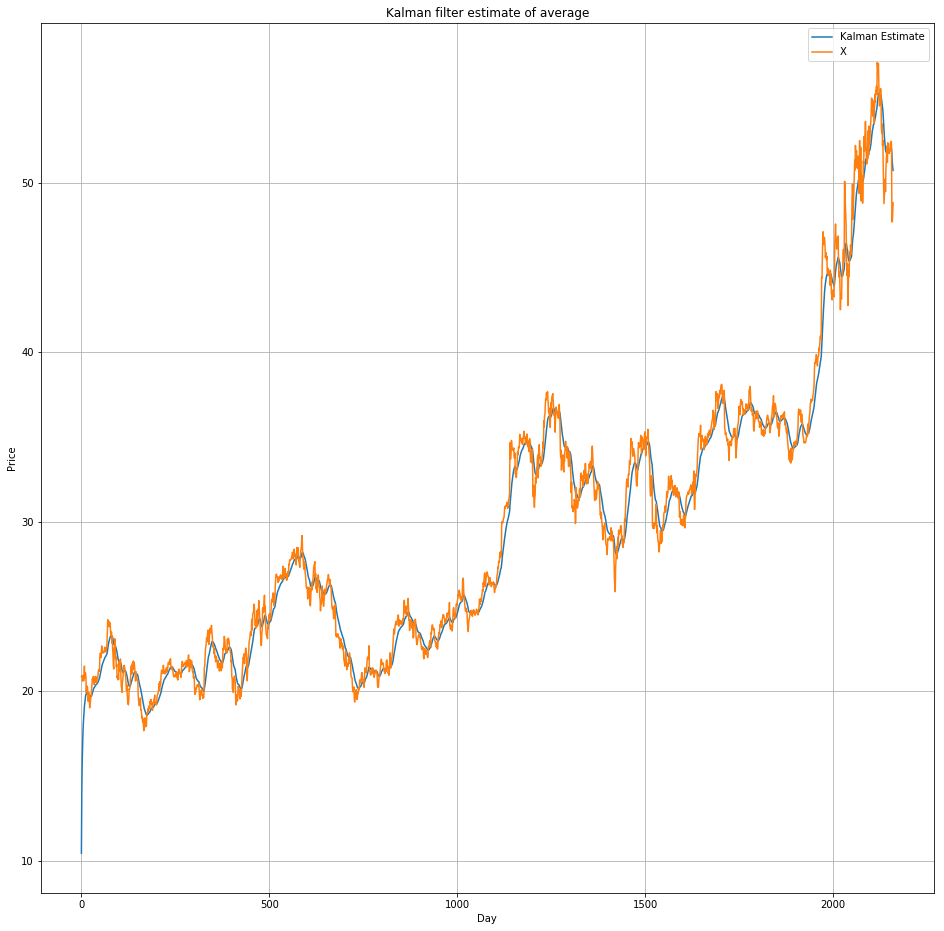

In [7]:
x = INTC['Close'].values
kf = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 0,
                  initial_state_covariance = 1,
                  observation_covariance=1,
                  transition_covariance=.01)
state_means, _ = kf.filter(x)
state_means = state_means.flatten()

plt.rc("figure",figsize=(16,16))
# Plot original data and estimated mean
plt.plot(state_means)
plt.plot(x)
plt.title('Kalman filter estimate of average')
plt.legend(['Kalman Estimate', 'X'])
plt.xlabel('Day')
plt.ylabel('Price');
plt.grid(True)
state_means = pd.DataFrame(data=state_means,index=INTC['Close'].index)
state_means.columns = ['KF']

# Add technical indicators and scale data with MaxAbsScaler or MinMaxScaler

In [8]:
result = pd.concat([INTC, MSFT[['Close']].rename(columns={'Close': 'MSFT'})], axis=1)
result = pd.concat([result, state_means.rename(columns={'KF': 'KF_mean'})], axis=1)
result = pd.concat([result, AMZN[['Close']].rename(columns={'Close': 'AMZN'})], axis=1)
result = pd.concat([result, NVDA[['Close']].rename(columns={'Close': 'NVDA'})], axis=1)
result = pd.concat([result, GOOG[['Close']].rename(columns={'Close': 'GOOG'})], axis=1)
result = pd.concat([result, NFLX[['Close']].rename(columns={'Close': 'NFLX'})], axis=1)
result = pd.concat([result, EUROSTOXX50[['Close']].rename(columns={'Close': 'EUROSTOXX50'})], axis=1)
result = pd.concat([result, SNP500[['Close']].rename(columns={'Close': 'SNP500'})], axis=1)
result = pd.concat([result, CONS_DESCRETE[['Close']].rename(columns={'Close': 'CONS_DESCRETE'})], axis=1)
result = pd.concat([result, SNP_TECH[['Close']].rename(columns={'Close': 'SNP_TECH'})], axis=1)
result = pd.concat([result, NASDAQ_COMP[['Close']].rename(columns={'Close': 'NASDAQ_COMP'})], axis=1)
result = pd.concat([result, VIX[['Close']].rename(columns={'Close': 'VIX'})], axis=1)

# distance to next extremes
[sup,res] = calc_extreme_distance(cl,extremes_sup,extremes_res) 
sr = pd.DataFrame(data=np.transpose([sup,res]),index=INTC.index )
sr.columns = ['support_distance', 'resistance_distance']
result = pd.concat([result, sr], axis=1)

# fred
result = pd.concat([result, yieldr[['5 YR']].rename(columns={'5 YR': 'yield_5y'})], axis=1)
result = pd.concat([result, tnote_y10.rename(columns={'Value': 'Tnote_10y'})], axis=1)

result = result.drop('Adj Close', axis=1)
result['Weekday'] = result.index.weekday
result['Daymonth'] = result.index.day
result['Month'] = result.index.month
result['Weakyear'] = result.index.weekofyear
#result = result.dropna()

In [9]:
result[['yield_5y']] = result[['yield_5y']].replace(0, 0.00000001)
result[['yield_5y']] = result[['yield_5y']]+10
result[['support_distance']] = result[['support_distance']].replace(0, 0.00000001)
result[['resistance_distance']] = result[['resistance_distance']].replace(0, 0.00000001)
logRet = result[['High','Low','Close','MSFT','AMZN','NVDA','GOOG','NFLX','EUROSTOXX50','SNP500',
                 'CONS_DESCRETE','SNP_TECH','NASDAQ_COMP','VIX','yield_5y','Tnote_10y']].apply(logReturns)

logRet.columns = [str(col) + '_logReturns' for col in logRet.columns]

result = pd.concat([result, logRet], axis=1)

In [10]:
momentum  =  result[['Close']].diff(periods=5)
momentum  =  momentum[~np.isnan(momentum)]
result['TradingRange'] = result["High"]-result["Low"]
result['OBV'] = on_balance_volume(result["Close"], result["Volume"])
result['TSI'] = tsi(result["Close"])
result['ATR'] = average_true_range(result["High"],result["Low"],result["Close"])
result['HighestHigh'] = result['High'].rolling(window=21,center=False,min_periods=1).max()
result['LowestLow'] = result['Low'].rolling(window=21,center=False,min_periods=1).min()

result['Volume'].fillna(method ='ffill', inplace=True)
scaler = prep.MaxAbsScaler().fit(result[['Volume']].values)
result['Volume_Scaled'] = scaler.transform(result[['Volume']].values)

result.head(3)

Open       High    Low      Close      Volume       MSFT  \
Date                                                                        
2010-01-04  20.790001  21.030001  20.73  20.879999  47800900.0  30.950001   
2010-01-05  20.940001  20.990000  20.60  20.870001  52357700.0  30.959999   
2010-01-06  20.809999  20.930000  20.67  20.799999  40037400.0  30.770000   

              KF_mean        AMZN       NVDA        GOOG      ...        \
Date                                                          ...         
2010-01-04  10.439999  133.899994  18.490000  311.349976      ...         
2010-01-05  13.962715  134.690002  18.760000  309.978882      ...         
2010-01-06  15.726883  132.250000  18.879999  302.164703      ...         

            VIX_logReturns  yield_5y_logReturns  Tnote_10y_logReturns  \
Date                                                                    
2010-01-04             NaN                  NaN                   NaN   
2010-01-05       -0.035038            -0.007634             -0.020998   
2010-01-06       -0.009868             0.000000              0.020998   

            TradingRange         OBV    TSI       ATR  HighestHigh  LowestLow  \
Date                                                                            
2010-01-04      0.300001         0.0    0.0  0.300001    21.030001      20.73   
2010-01-05      0.390000 -52357700.0 -100.0  0.346552    21.030001      20.60   
2010-01-06      0.260000 -40037400.0 -100.0  0.315690    21.030001      20.60   

            Volume_Scaled  
Date                       
2010-01-04       0.240202  
2010-01-05       0.263101  
2010-01-06       0.201190  

[3 rows x 48 columns]

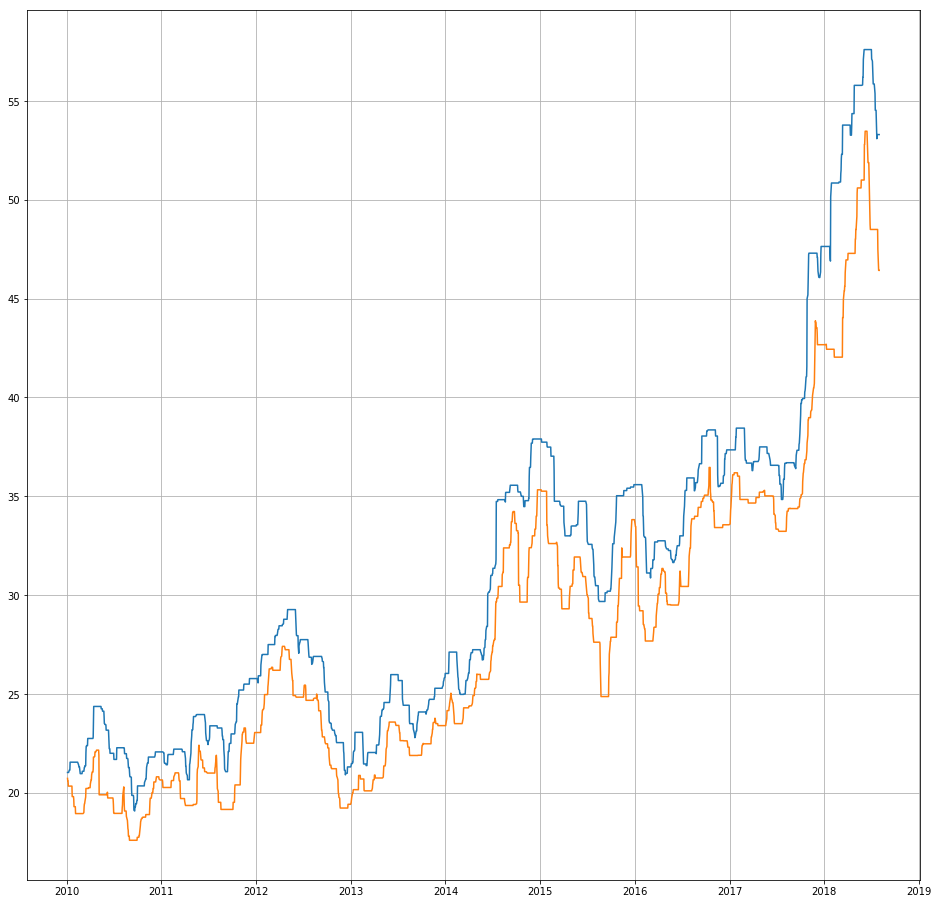

In [11]:
from matplotlib.pyplot import figure
plt.rc("figure",figsize=(16,16))
plt.plot(result['HighestHigh'])
plt.plot(result['LowestLow'])
plt.grid(True)

In [12]:
scaler = prep.MaxAbsScaler().fit(result[['ATR']].values)
result['ATR_Scaled'] = scaler.transform(result[['ATR']].values)

scaler = prep.MaxAbsScaler().fit(result[['TSI']].values)
result['TSI_Scaled'] = scaler.transform(result[['TSI']].values)

scaler = prep.MaxAbsScaler().fit(result[['OBV']].values)
result['OBV_Scaled'] = scaler.transform(result[['OBV']].values)

result['TradingRange'].fillna(method ='ffill', inplace=True)
scaler = prep.MaxAbsScaler().fit(result[['TradingRange']].values)
result['TradingRange_Scaled'] = scaler.transform(result[['TradingRange']].values)

scaler = prep.MaxAbsScaler().fit(result[['HighestHigh']].values)
result['HighestHigh_Scaled'] = scaler.transform(result[['HighestHigh']].values)

scaler = prep.MaxAbsScaler().fit(result[['LowestLow']].values)
result['LowestLow_Scaled'] = scaler.transform(result[['LowestLow']].values)

result['KF_mean'].fillna(method ='ffill', inplace=True)
scaler = prep.MaxAbsScaler().fit(result[['KF_mean']].values)
result['KFMean_Scaled'] = scaler.transform(result[['KF_mean']].values)

result['support_distance'].fillna(method ='ffill', inplace=True)
scaler = prep.MaxAbsScaler().fit(result[['support_distance']].values)
result['support_distance_Scaled'] = scaler.transform(result[['support_distance']].values)

result['resistance_distance'].fillna(method ='ffill', inplace=True)
scaler = prep.MaxAbsScaler().fit(result[['resistance_distance']].values)
result['resistance_distance_Scaled'] = scaler.transform(result[['resistance_distance']].values)

result = result.iloc[5:]

In [13]:
result['TSI_Scaled'] =  result['TSI_Scaled'].replace(-1,0)
result['TSI_Scaled'] =  result['TSI_Scaled'].replace(0,0.00000001)
result = result.drop('TSI', axis=1)
result = result.drop('ATR', axis=1)
result = result.drop('OBV', axis=1)
result = result.drop('TradingRange', axis=1)
result = result.drop('HighestHigh', axis=1)
result = result.drop('LowestLow', axis=1)

# Insert learning target

In [14]:
# Shift to n period to predict next n period
predict_step = 3
y = result.shift(periods=predict_step)
y.fillna(0, inplace=True)
y = y['Close_logReturns']
result['Target'] = y

In [15]:
train_data = result.drop(['Open', 'High','Low','Close','Volume','MSFT','AMZN','NVDA','GOOG','NFLX'
                          ,'EUROSTOXX50','SNP500','CONS_DESCRETE','SNP_TECH','NASDAQ_COMP','yield_5y'
                          ,'Tnote_10y','support_distance','resistance_distance'], axis=1)

In [16]:
pd.set_option('display.max_columns', 100)
train_data.head(11)

KF_mean        VIX  Weekday  Daymonth  Month  Weakyear  \
Date                                                                   
2010-01-11  18.049804  17.549999        0        11      1         2   
2010-01-12  18.422815  18.250000        1        12      1         2   
2010-01-13  18.764626  17.850000        2        13      1         2   
2010-01-14  19.107916  17.629999        3        14      1         2   
2010-01-15  19.311045  17.910000        4        15      1         2   
2010-01-19  19.511166  17.580000        1        19      1         3   
2010-01-20  19.685582  18.680000        2        20      1         3   
2010-01-21  19.810350  22.270000        3        21      1         3   
2010-01-22  19.820874  27.309999        4        22      1         3   
2010-01-25  19.872597  25.410000        0        25      1         4   
2010-01-26  19.885597  24.549999        1        26      1         4   

            High_logReturns  Low_logReturns  Close_logReturns  \
Date                                                            
2010-01-11         0.012369        0.020379          0.005744   
2010-01-12        -0.011891       -0.021360         -0.016362   
2010-01-13         0.008576        0.002940          0.016839   
2010-01-14         0.022051        0.029407          0.024506   
2010-01-15        -0.006985       -0.013391         -0.032169   
2010-01-19        -0.010806        0.003844          0.011948   
2010-01-20        -0.001418        0.000000          0.001424   
2010-01-21         0.008009       -0.008187         -0.011451   
2010-01-22        -0.024704       -0.042980         -0.045652   
2010-01-25        -0.010152        0.016521          0.020384   
2010-01-26        -0.009766       -0.009479         -0.015873   

            MSFT_logReturns  AMZN_logReturns  NVDA_logReturns  \
Date                                                            
2010-01-11        -0.012802        -0.024335        -0.014115   
2010-01-12        -0.006629        -0.022977        -0.034486   
2010-01-13         0.009269         0.013726         0.013491   
2010-01-14         0.019899        -0.013726        -0.015757   
2010-01-15        -0.003235        -0.001650        -0.029939   
2010-01-19         0.007747         0.003690         0.018530   
2010-01-20        -0.016535        -0.014444        -0.004024   
2010-01-21        -0.019142         0.006656        -0.018019   
2010-01-22        -0.035615        -0.041853        -0.035217   
2010-01-25         0.012354        -0.009266         0.016868   
2010-01-26         0.006120        -0.006923        -0.032173   

            GOOG_logReturns  NFLX_logReturns  EUROSTOXX50_logReturns  \
Date                                                                   
2010-01-11        -0.001513        -0.001314                0.006051   
2010-01-12        -0.017842        -0.016288               -0.017555   
2010-01-13        -0.005758         0.029909                0.009401   
2010-01-14         0.004690        -0.056613                0.004435   
2010-01-15        -0.016840        -0.000785               -0.030983   
2010-01-19         0.013052         0.004895                0.011939   
2010-01-20        -0.012346         0.000781               -0.034041   
2010-01-21         0.004418        -0.000976               -0.034986   
2010-01-22        -0.058216        -0.005878               -0.015894   
2010-01-25        -0.018367        -0.035197                0.006953   
2010-01-26         0.004471         0.016553               -0.002569   

            SNP500_logReturns  CONS_DESCRETE_logReturns  SNP_TECH_logReturns  \
Date                                                                           
2010-01-11           0.001745                 -0.001976            -0.003914   
2010-01-12          -0.009425                 -0.012942            -0.010953   
2010-01-13           0.008291                  0.011292             0.009645   
2010-01-14           0.002423                  0

In [17]:
train_data = train_data.dropna()

In [18]:
print("result datapoints:" + str(len(result)) + ", train datapoints:"+ str(len(train_data)))

result datapoints:2159, train datapoints:2116


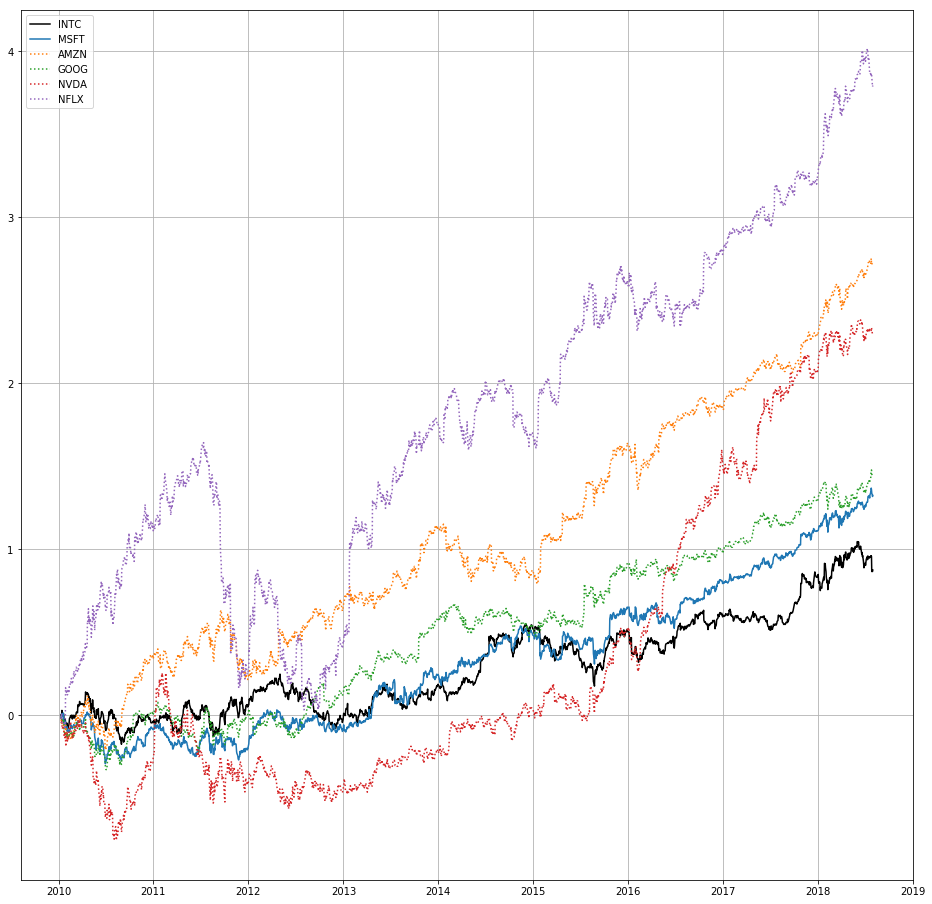

In [19]:
# Plot intel log returns to other 
plt.rc("figure",figsize=(16,16))
plt.plot(np.cumsum(train_data[['Close_logReturns']]), color='xkcd:black',linestyle ='-')
plt.plot(np.cumsum(train_data[['MSFT_logReturns']]),linestyle ='-')
plt.plot(np.cumsum(train_data[['AMZN_logReturns']]),linestyle =':')
plt.plot(np.cumsum(train_data[['GOOG_logReturns']]),linestyle =':')
plt.plot(np.cumsum(train_data[['NVDA_logReturns']]),linestyle =':')
plt.plot(np.cumsum(train_data[['NFLX_logReturns']]),linestyle =':')
plt.legend(['INTC','MSFT','AMZN','GOOG','NVDA','NFLX','FB'], loc='upper left')
plt.grid(True)
plt.show()

# Plot correlation heat map

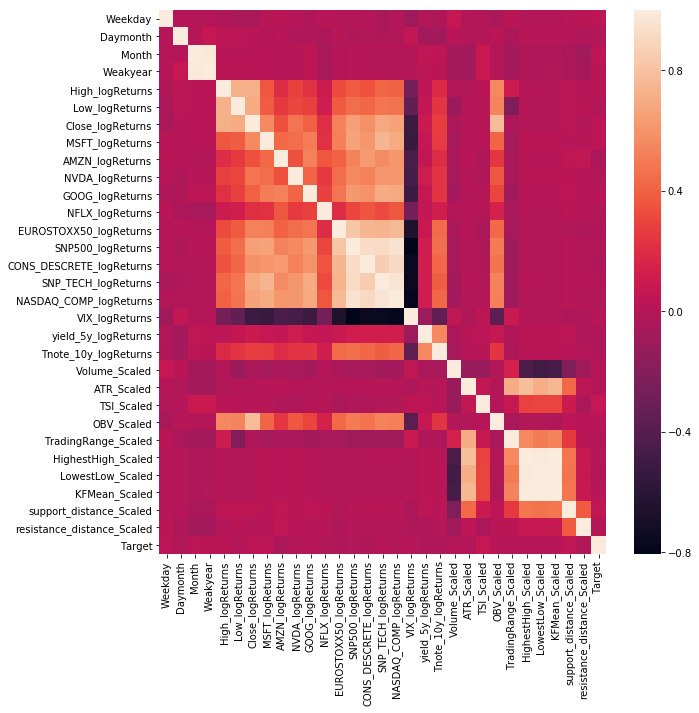

In [20]:
train_data = train_data.drop(['KF_mean','VIX'], axis=1)
corr = train_data.corr()
size = 10
fig, ax = plt.subplots(figsize=(size, size))
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()

# properties of train_data

In [72]:
print ("Train dataset:")
print ("Number of data points: ", len(train_data.index))
print ("Number of days: ", train_data.index.nunique())
print ("Number of features: ", train_data.shape[1] - 5)
n_features = train_data.shape[1] - 5
# The sparsity is the subdivision of each side of a n_feature dimensional 
# cube that would result in a single observation per subdivision on average.
# The lower it is, the harder you’ll be hit by the curse of dimensionality. 
# It gives an idea of the density of the samples adjusted for the number of features. 
# Despite the large number of samples and reasonable number of features, we only need to cut the 
# hypercube x times along each axis on average to isolate each sample.
print ("Sparsity of the training data: " +  str(np.exp(np.log(train_data.shape[0])/n_features)))

Train dataset:
Number of data points:  2116
Number of days:  2116
Number of features:  26
Sparsity of the training data: 1.3424695648659721


In [73]:
train_data

Weekday  Daymonth  Month  Weakyear  High_logReturns  \
Date                                                              
2010-01-11        0        11      1         2         0.012369   
2010-01-12        1        12      1         2        -0.011891   
2010-01-13        2        13      1         2         0.008576   
2010-01-14        3        14      1         2         0.022051   
2010-01-15        4        15      1         2        -0.006985   
2010-01-19        1        19      1         3        -0.010806   
2010-01-20        2        20      1         3        -0.001418   
2010-01-21        3        21      1         3         0.008009   
2010-01-22        4        22      1         3        -0.024704   
2010-01-25        0        25      1         4        -0.010152   
2010-01-26        1        26      1         4        -0.009766   
2010-01-27        2        27      1         4        -0.002456   
2010-01-28        3        28      1         4         0.002947   
2010-01-29        4        29      1         4        -0.007878   
2010-02-01        0         1      2         5        -0.024013   
2010-02-02        1         2      2         5         0.014577   
2010-02-03        2         3      2         5        -0.008016   
2010-02-04        3         4      2         5        -0.015206   
2010-02-05        4         5      2         5         0.000000   
2010-02-08        0         8      2         6         0.010668   
2010-02-09        1         9      2         6         0.005040   
2010-02-10        2        10      2         6        -0.001006   
2010-02-11        3        11      2         6         0.016472   
2010-02-12        4        12      2         6         0.023484   
2010-02-16        1        16      2         7         0.008187   
2010-02-17        2        17      2         7         0.000480   
2010-02-18        3        18      2         7        -0.000480   
2010-02-19        4        19      2         7         0.005739   
2010-02-22        0        22      2         8        -0.000477   
2010-02-23        1        23      2         8        -0.000477   
...             ...       ...    ...       ...              ...   
2018-06-19        1        19      6        25        -0.025176   
2018-06-20        2        20      6        25         0.014996   
2018-06-21        3        21      6        25         0.014407   
2018-06-22        4        22      6        25        -0.026762   
2018-06-25        0        25      6        26        -0.025564   
2018-06-26        1        26      6        26        -0.026235   
2018-06-27        2        27      6        26        -0.006967   
2018-06-28        3        28      6        26        -0.011452   
2018-06-29        4        29      6        26         0.012450   
2018-07-02        0         2      7        27         0.003188   
2018-07-03        1         3      7        27         0.011668   
2018-07-05        3         5      7        27         0.001964   
2018-07-06        4         6      7        27         0.010541   
2018-07-09        0         9      7        28         0.007544   
2018-07-10        1        10      7        28         0.007105   
2018-07-11        2        11      7        28        -0.007491   
2018-07-12        3        12      7        28         0.011692   
2018-07-13        4        13      7        28        -0.001144   
2018-07-16        0        16      7        29        -0.001909   
2018-07-17        1        17      7        29        -0.008445   
2018-07-18        2        18      7        29         0.001733   
2018-07-19        3        19      7        29         0.000769   
2018-07-20        4        20      7        29         0.001153   
2018-07-23        0        23      7        30         0.008224   
2018-07-24        1        24      7        30         0.015123   
2018-07-25        2        25      7        30        -0.016076   
2018-07-26        3        26      7        30         0.01

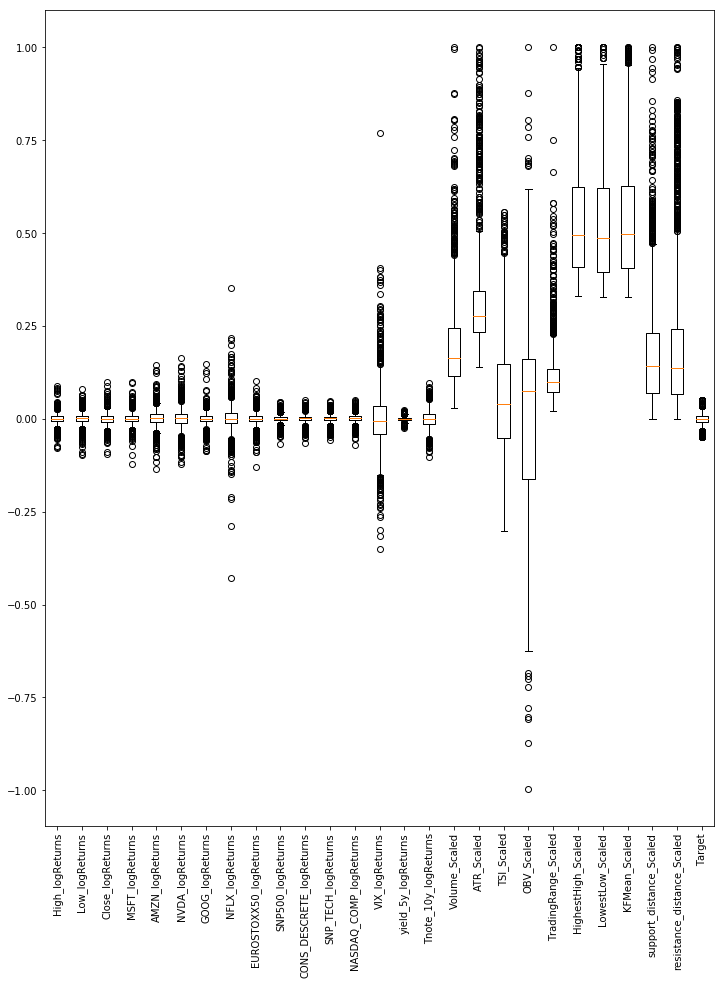

In [85]:
plt.figure(figsize=(12,15))
dat = train_data.drop(['Weekday','Daymonth','Weakyear','Month'],axis=1)
plt.boxplot(dat.values, labels = dat.columns)
plt.xticks(rotation=90)
plt.show()

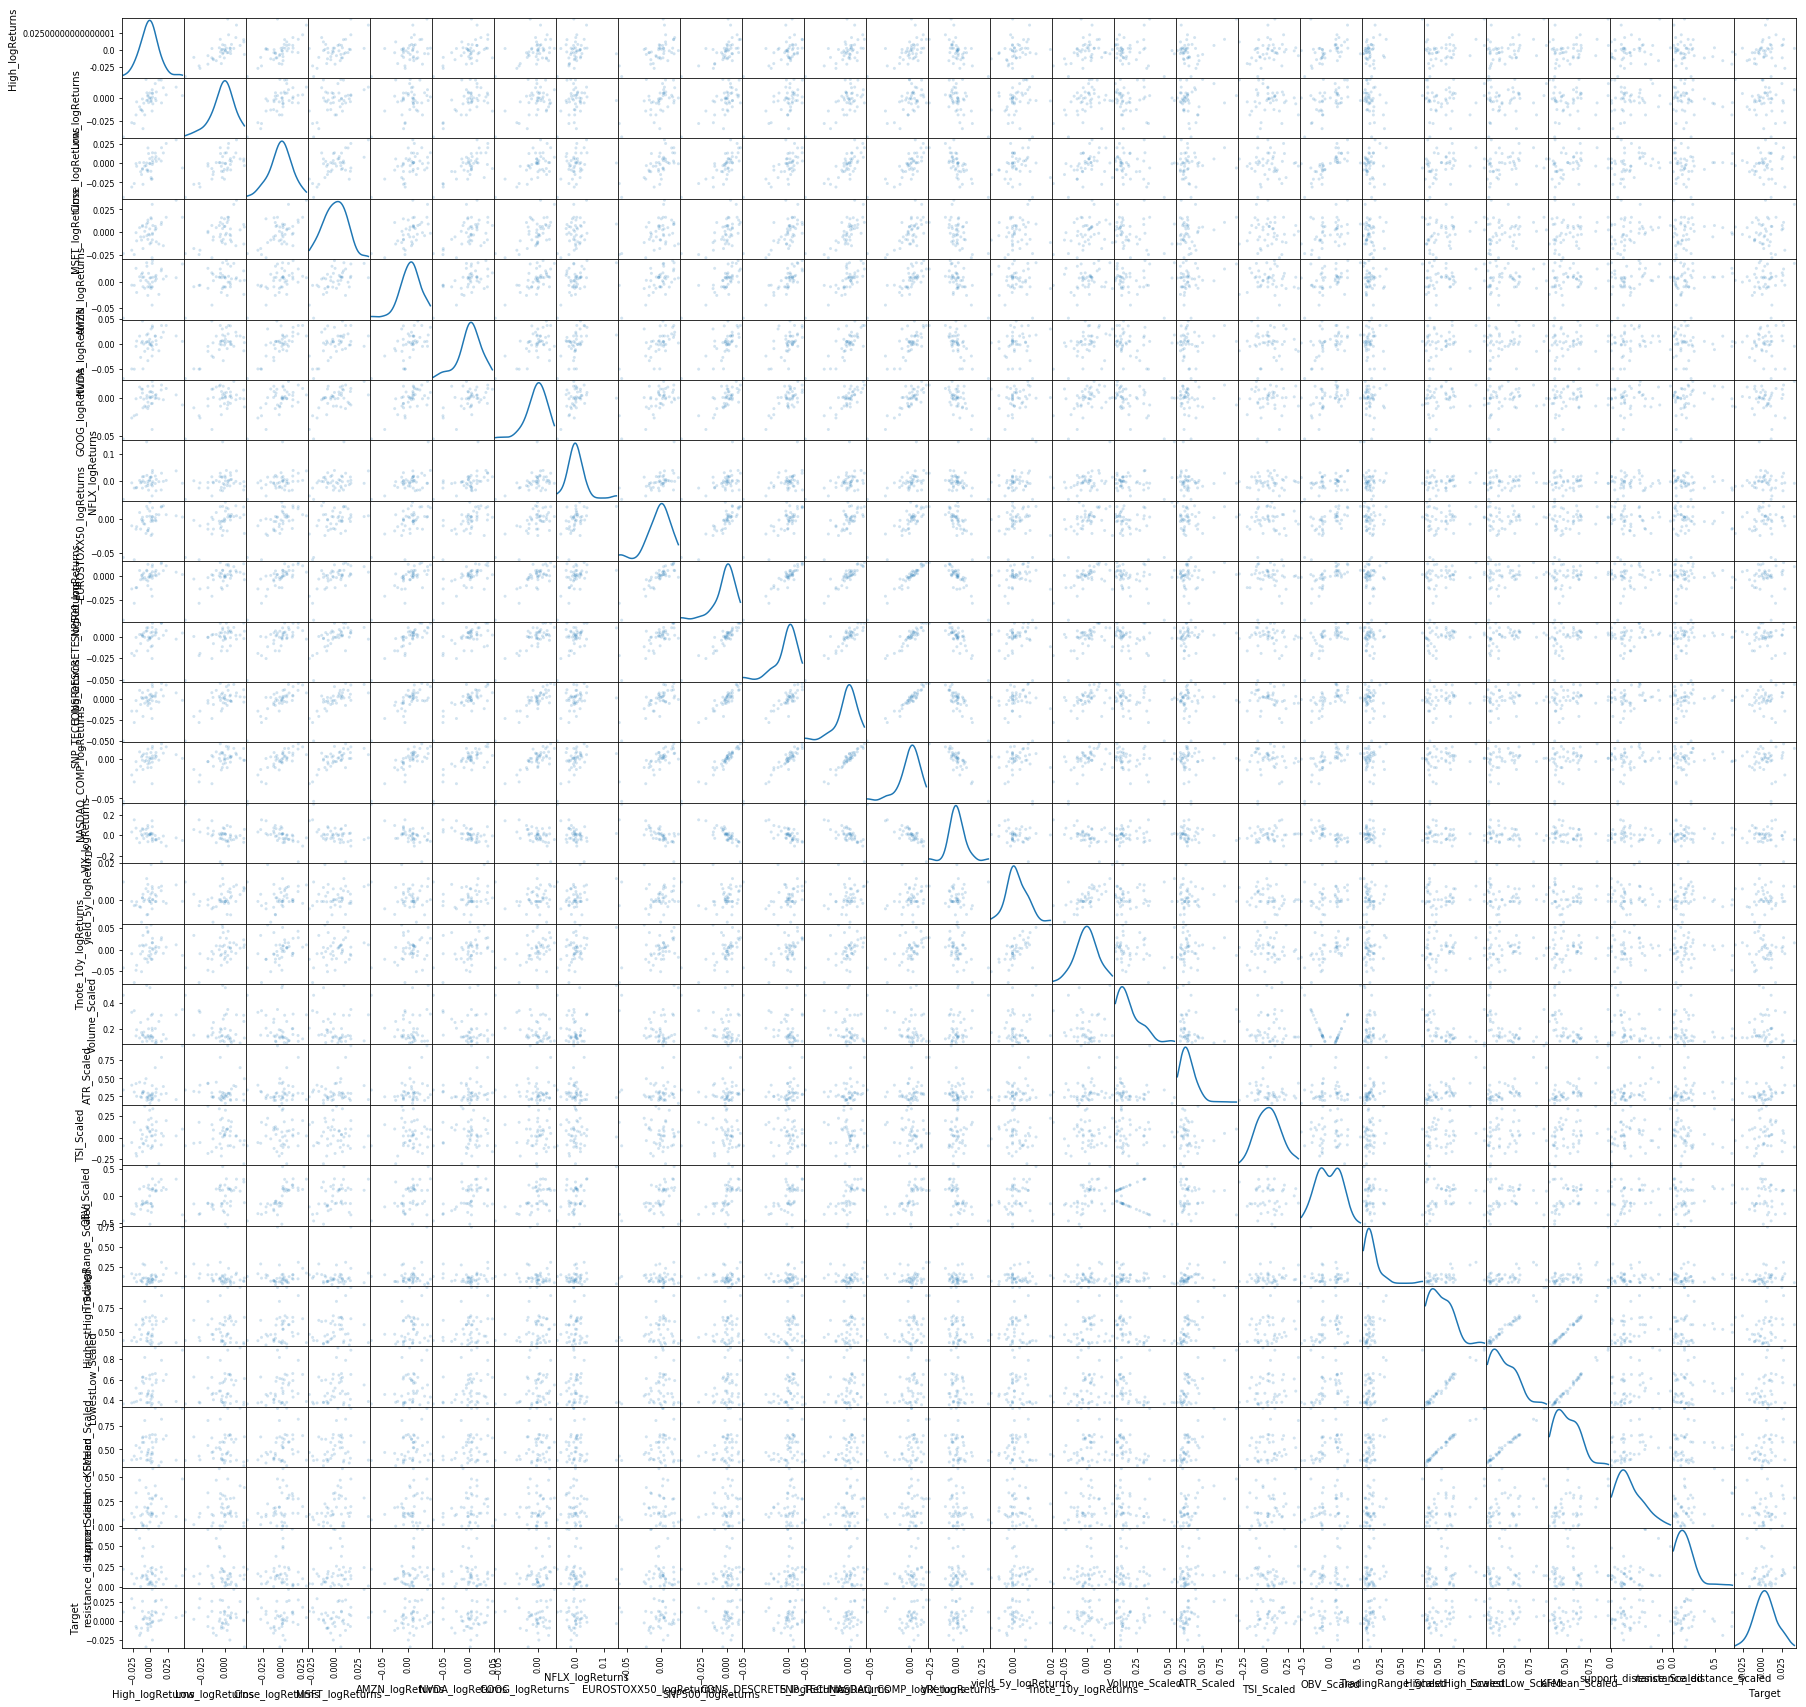

In [21]:
pd.plotting.scatter_matrix(train_data.iloc[::50].select_dtypes(include=['int', 'float']), alpha=0.2, figsize=(30, 30), diagonal='kde')
plt.show()

In [22]:
train_data.describe()

Weekday     Daymonth        Month     Weakyear  High_logReturns  \
count  2116.000000  2116.000000  2116.000000  2116.000000      2116.000000   
mean      2.039698    15.793478     6.334121    25.720227         0.000402   
std       1.395139     8.763203     3.384625    14.757814         0.013190   
min       0.000000     1.000000     1.000000     1.000000        -0.077789   
25%       1.000000     8.000000     3.000000    13.000000        -0.006139   
50%       2.000000    16.000000     6.000000    25.000000         0.000436   
75%       3.000000    23.000000     9.000000    38.000000         0.007304   
max       4.000000    31.000000    12.000000    53.000000         0.088426   

       Low_logReturns  Close_logReturns  MSFT_logReturns  AMZN_logReturns  \
count     2116.000000       2116.000000      2116.000000      2116.000000   
mean         0.000404          0.000414         0.000627         0.001279   
std          0.014092          0.015042         0.014229         0.019425   
min         -0.096204         -0.095432        -0.121033        -0.135325   
25%         -0.006493         -0.007703        -0.006734        -0.008166   
50%          0.000944          0.000555         0.000351         0.001086   
75%          0.007792          0.008553         0.008026         0.011695   
max          0.079817          0.100315         0.099413         0.146225   

       NVDA_logReturns  GOOG_logReturns  NFLX_logReturns  \
count      2116.000000      2116.000000      2116.000000   
mean          0.001085         0.000680         0.001793   
std           0.023821         0.015165         0.033557   
min          -0.122573        -0.087493        -0.429179   
25%          -0.010984        -0.006313        -0.012289   
50%           0.001002         0.000473         0.000478   
75%           0.012877         0.008422         0.016214   
max           0.164038         0.148872         0.352230   

       EUROSTOXX50_logReturns  SNP500_logReturns  CONS_DESCRETE_logReturns  \
count             2116.000000        2116.000000               2116.000000   
mean                 0.000003           0.000458                  0.000628   
std                  0.015725           0.009330                  0.010191   
min                 -0.130242          -0.068958                 -0.064795   
25%                 -0.006862          -0.003264                 -0.004280   
50%                  0.000827           0.000605                  0.001142   
75%                  0.007920           0.005059                  0.006225   
max                  0.102831           0.046317                  0.050889   

       SNP_TECH_logReturns  NASDAQ_COMP_logReturns  VIX_logReturns  \
count          2116.000000             2116.000000     2116.000000   
mean              0.000562                0.000599       -0.000618   
std               0.010266                0.010584        0.077137   
min              -0.057957               -0.071489       -0.350589   
25%              -0.004101               -0.003929       -0.041998   
50%               0.000931                0.000968       -0.005884   
75%               0.006024                0.006307        0.033994   
max               0.049169                0.051592        0.768245   

       yield_5y_logReturns  Tnote_10y_logReturns  Volume_Scaled   ATR_Scaled  \
count          2116.000000           2116.000000    2116.000000  2116.000000   
mean              0.000008             -0.000094       0.196913     0.316297   
std               0.004964              0.021782       0.116904     0.138496   
min              -0.024718             -0.102809       0.029617     0.139119   
25%              -0.002963             -0.013323       0.115351     0.234632   
50%               0.000000              0.000000       0.162955     0.278132   
75%               0.002954              0.013030       0.245180     0.343519   
max               0.023222              0.096277       1.000000     1.000000   

        TSI_Scaled

In [23]:
df_corr = train_data[['Close_logReturns','MSFT_logReturns','AMZN_logReturns','GOOG_logReturns','NVDA_logReturns',
                       'NFLX_logReturns']]

Close_logReturns  MSFT_logReturns  AMZN_logReturns  \
Close_logReturns          1.000000         0.561790         0.339599   
MSFT_logReturns           0.561790         1.000000         0.432460   
AMZN_logReturns           0.339599         0.432460         1.000000   
GOOG_logReturns           0.394904         0.508354         0.527265   
NVDA_logReturns           0.475034         0.446325         0.340767   
NFLX_logReturns           0.203629         0.223590         0.360115   

                  GOOG_logReturns  NVDA_logReturns  NFLX_logReturns  
Close_logReturns         0.394904         0.475034         0.203629  
MSFT_logReturns          0.508354         0.446325         0.223590  
AMZN_logReturns          0.527265         0.340767         0.360115  
GOOG_logReturns          1.000000         0.407964         0.284941  
NVDA_logReturns          0.407964         1.000000         0.255646  
NFLX_logReturns          0.284941         0.255646         1.000000

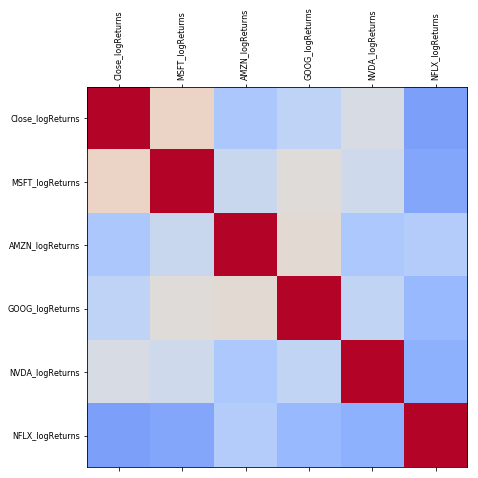

In [24]:
df = df_corr.corr()
import matplotlib.cm as cm
size = 7
fig, ax = plt.subplots(figsize=(size, size))
ax.matshow(df,cmap=cm.get_cmap('coolwarm'), vmin=0,vmax=1)
plt.xticks(range(len(df.columns)), df.columns, rotation='vertical', fontsize=8);
plt.yticks(range(len(df.columns)), df.columns, fontsize=8);
df

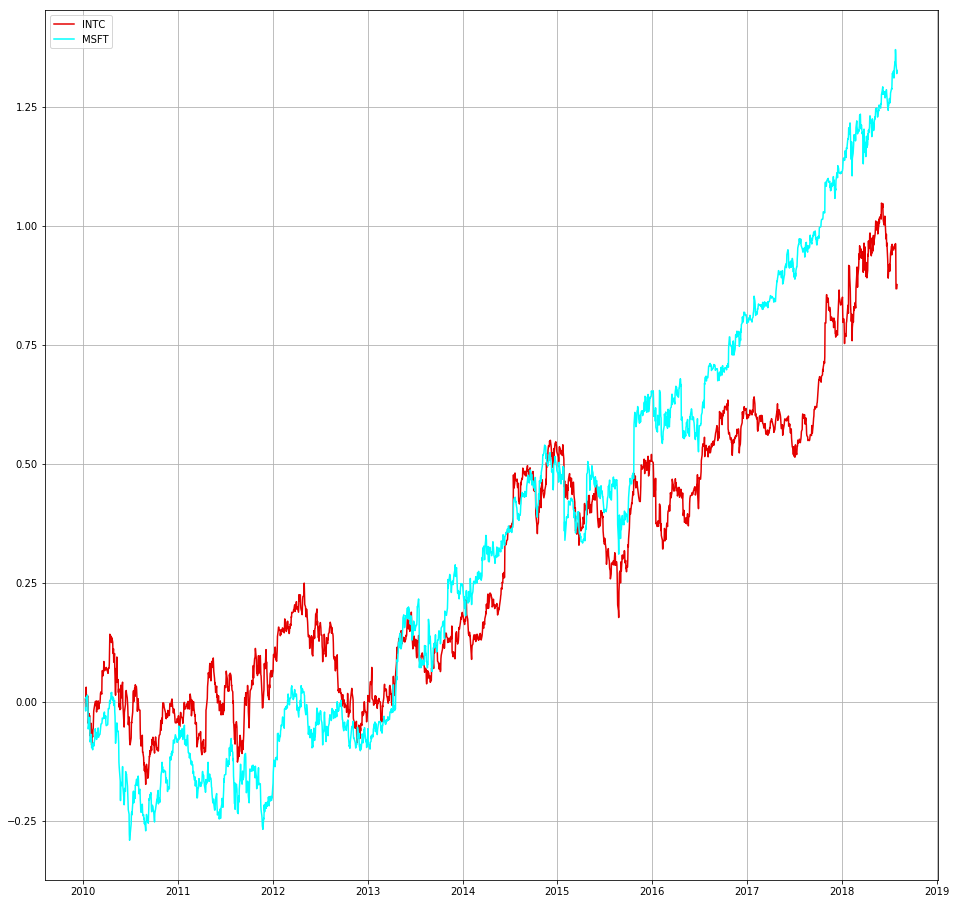

In [25]:
from matplotlib.pyplot import figure
plt.rc("figure",figsize=(16,16))
plt.plot(np.cumsum(train_data[['Close_logReturns']]), color='xkcd:red',linestyle ='-')
plt.plot(np.cumsum(train_data[['MSFT_logReturns']]),color='xkcd:cyan',linestyle ='-')
plt.grid(True,which ='both')
plt.legend(['INTC','MSFT'], loc='upper left')

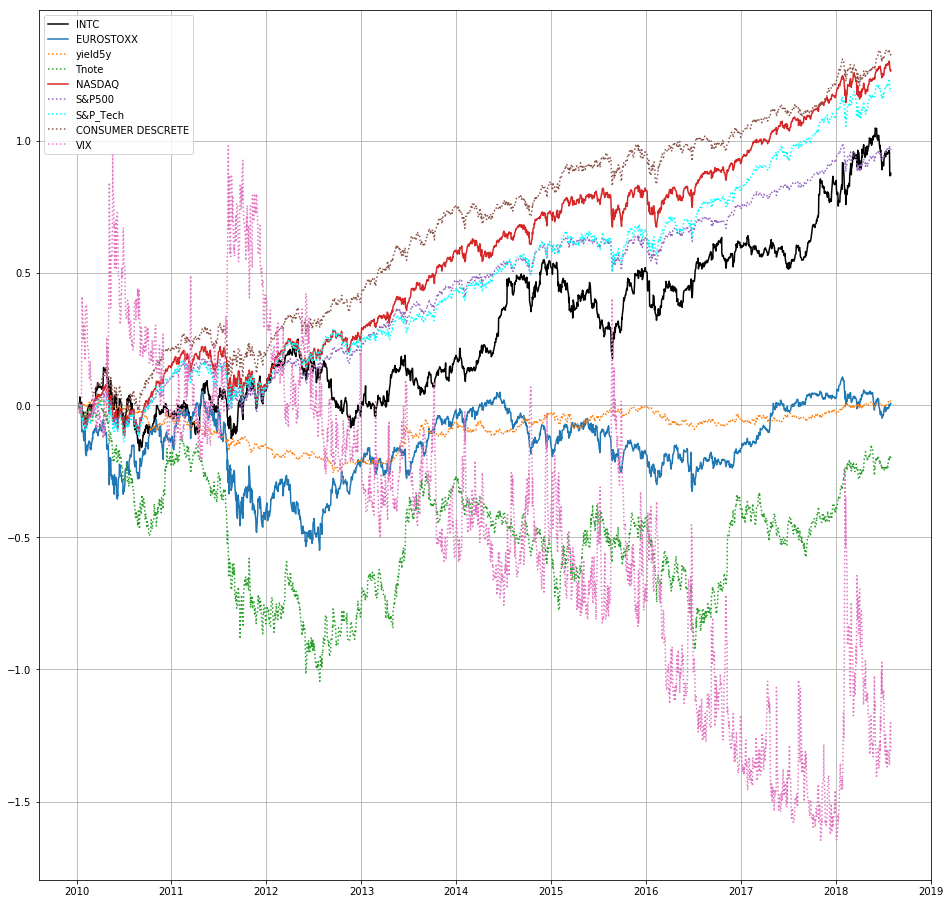

In [26]:
# Plot intel log returns to macro
from matplotlib.pyplot import figure
plt.rc("figure",figsize=(16,16))
plt.plot(np.cumsum(train_data[['Close_logReturns']]), color='xkcd:black',linestyle ='-')
plt.plot(np.cumsum(train_data[['EUROSTOXX50_logReturns']]),linestyle ='-')
plt.plot(np.cumsum(train_data[['yield_5y_logReturns']]),linestyle =':')
plt.plot(np.cumsum(train_data[['Tnote_10y_logReturns']]),linestyle =':')
plt.plot(np.cumsum(train_data[['NASDAQ_COMP_logReturns']]),linestyle ='-')
plt.plot(np.cumsum(train_data[['SNP500_logReturns']]),linestyle =':')
plt.plot(np.cumsum(train_data[['SNP_TECH_logReturns']]),color='xkcd:cyan',linestyle =':')
plt.plot(np.cumsum(train_data[['CONS_DESCRETE_logReturns']]),linestyle =':')
plt.plot(np.cumsum(train_data[['VIX_logReturns']]),linestyle =':')
plt.legend(['INTC','EUROSTOXX','yield5y','Tnote','NASDAQ','S&P500','S&P_Tech','CONSUMER DESCRETE','VIX'], loc='upper left')
plt.grid(True)
plt.show()

In [27]:
df_corr2 = train_data[['Close_logReturns','EUROSTOXX50_logReturns','yield_5y_logReturns','Tnote_10y_logReturns','NASDAQ_COMP_logReturns',
                       'SNP500_logReturns','SNP_TECH_logReturns','CONS_DESCRETE_logReturns','VIX_logReturns']]

Close_logReturns  EUROSTOXX50_logReturns  \
Close_logReturns                  1.000000                0.524031   
EUROSTOXX50_logReturns            0.524031                1.000000   
yield_5y_logReturns               0.092441                0.084536   
Tnote_10y_logReturns              0.269766                0.439268   
NASDAQ_COMP_logReturns            0.661903                0.760391   
SNP500_logReturns                 0.646370                0.823314   
SNP_TECH_logReturns               0.693597                0.738676   
CONS_DESCRETE_logReturns          0.584105                0.747214   
VIX_logReturns                   -0.516439               -0.661682   

                          yield_5y_logReturns  Tnote_10y_logReturns  \
Close_logReturns                     0.092441              0.269766   
EUROSTOXX50_logReturns               0.084536              0.439268   
yield_5y_logReturns                  1.000000              0.554191   
Tnote_10y_logReturns                 0.554191              1.000000   
NASDAQ_COMP_logReturns               0.115496              0.423883   
SNP500_logReturns                    0.115523              0.455146   
SNP_TECH_logReturns                  0.114593              0.393283   
CONS_DESCRETE_logReturns             0.123046              0.428289   
VIX_logReturns                      -0.103123             -0.354895   

                          NASDAQ_COMP_logReturns  SNP500_logReturns  \
Close_logReturns                        0.661903           0.646370   
EUROSTOXX50_logReturns                  0.760391           0.823314   
yield_5y_logReturns                     0.115496           0.115523   
Tnote_10y_logReturns                    0.423883           0.455146   
NASDAQ_COMP_logReturns                  1.000000           0.952811   
SNP500_logReturns                       0.952811           1.000000   
SNP_TECH_logReturns                     0.958908           0.919287   
CONS_DESCRETE_logReturns                0.914780           0.924319   
VIX_logReturns                         -0.777942          -0.805439   

                          SNP_TECH_logReturns  CONS_DESCRETE_logReturns  \
Close_logReturns                     0.693597                  0.584105   
EUROSTOXX50_logReturns               0.738676                  0.747214   
yield_5y_logReturns                  0.114593                  0.123046   
Tnote_10y_logReturns                 0.393283                  0.428289   
NASDAQ_COMP_logReturns               0.958908                  0.914780   
SNP500_logReturns                    0.919287                  0.924319   
SNP_TECH_logReturns                  1.000000                  0.855701   
CONS_DESCRETE_logReturns             0.855701                  1.000000   
VIX_logReturns                      -0.752291                 -0.750193   

                          VIX_logReturns  
Close_logReturns               -0.516439  
EUROSTOXX50_logReturns         -0.661682  
yield_5y_logReturns            -0.103123  
Tnote_10y_logReturns           -0.354895  
NASDAQ_COMP_logReturns         -0.777942  
SNP500_logReturns              -0.805439  
SNP_TECH_logReturns            -0.752291  
CONS_DESCRETE_logReturns       -0.750193  
VIX_logReturns                  1.000000

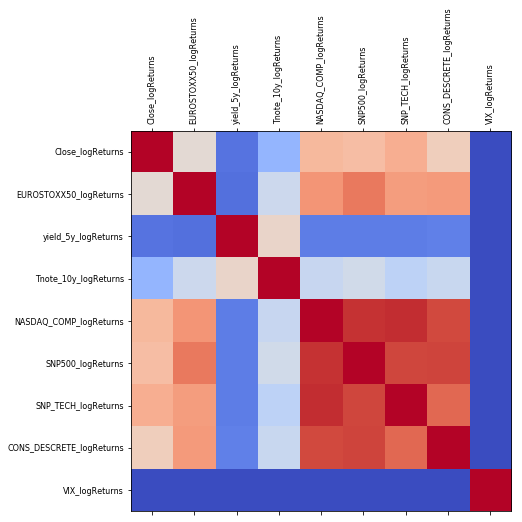

In [28]:
df = df_corr2.corr()
import matplotlib.cm as cm
size = 7
fig, ax = plt.subplots(figsize=(size, size))
ax.matshow(df,cmap=cm.get_cmap('coolwarm'), vmin=0,vmax=1)
plt.xticks(range(len(df.columns)), df.columns, rotation='vertical', fontsize=8);
plt.yticks(range(len(df.columns)), df.columns, fontsize=8);
df

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sign
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sign
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in sign
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sign
  


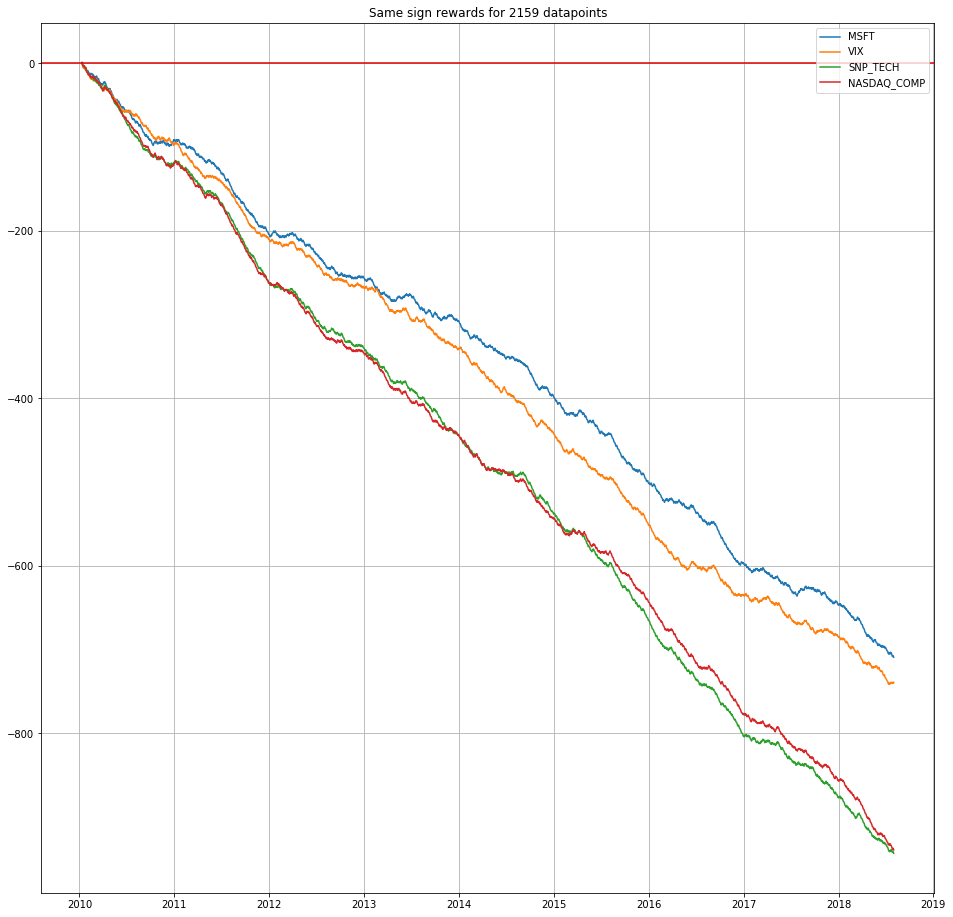

In [29]:
# MSFT same sign
diff_sign = np.sign(result['Close_logReturns']) != np.sign(result['MSFT_logReturns'])
diff_sign = diff_sign.replace(True,1).replace(False,-1)

# VIX opposite sign
diff_sign_vix = np.sign(result['Close_logReturns']) != np.sign(result['VIX_logReturns'])
diff_sign_vix = diff_sign_vix.replace(True,-1).replace(False,1)

# SNP Tech same sign
diff_sign_spt = np.sign(result['Close_logReturns']) != np.sign(result['SNP_TECH_logReturns'])
diff_sign_spt = diff_sign_spt.replace(True,1).replace(False,-1)

# Nasdaq Composite same sign
diff_sign_ndc = np.sign(result['Close_logReturns']) != np.sign(result['NASDAQ_COMP_logReturns'])
diff_sign_ndc = diff_sign_ndc.replace(True,1).replace(False,-1)

plt.rc("figure",figsize=(16,16))
plt.plot(np.cumsum(diff_sign))
plt.plot(np.cumsum(diff_sign_vix))
plt.plot(np.cumsum(diff_sign_spt))
plt.plot(np.cumsum(diff_sign_ndc))
plt.axhline(y=0,color='xkcd:red',linestyle ='-')
plt.legend(['MSFT','VIX','SNP_TECH','NASDAQ_COMP'], loc='upper right')
plt.grid(True)
plt.title("Same sign rewards for " + str(len(diff_sign)) +" datapoints")
plt.show()

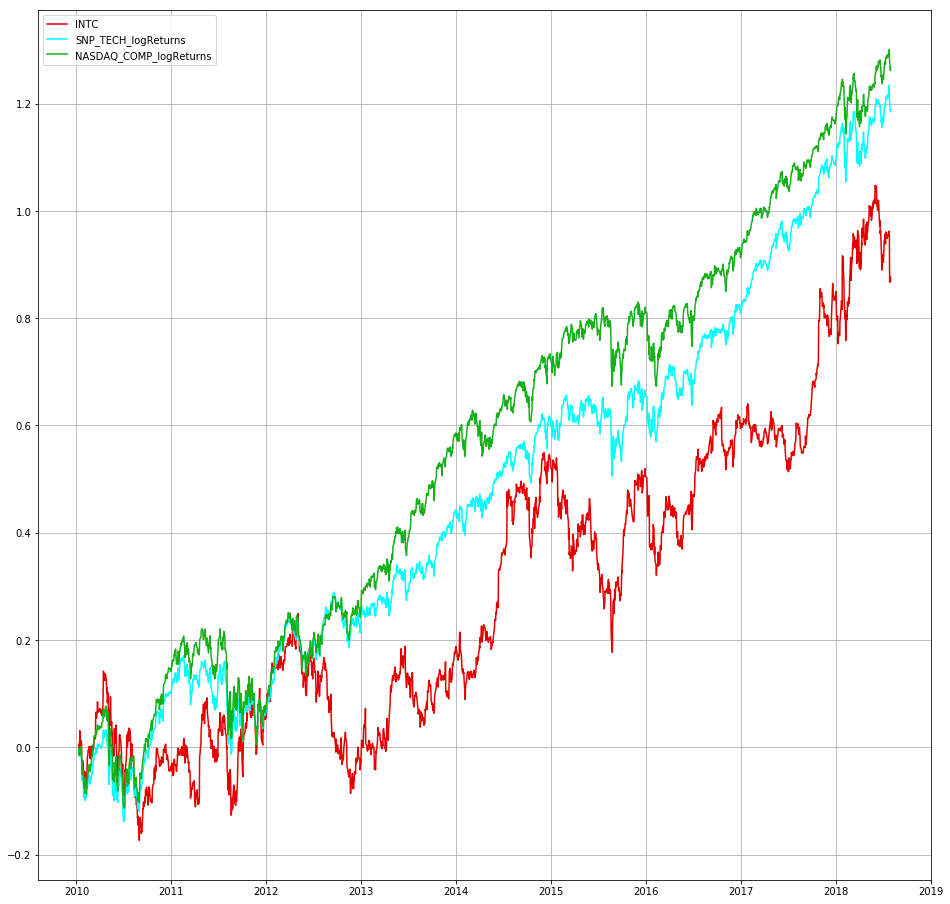

In [30]:
# Plot cumsum of returns Close,SNP_Tech, Nasdaq Comp
from matplotlib.pyplot import figure
plt.rc("figure",figsize=(16,16))
plt.plot(np.cumsum(train_data[['Close_logReturns']]), color='xkcd:red',linestyle ='-')
plt.plot(np.cumsum(train_data[['SNP_TECH_logReturns']]),color='xkcd:cyan',linestyle ='-')
plt.plot(np.cumsum(train_data[['NASDAQ_COMP_logReturns']]),color='xkcd:green',linestyle ='-')
plt.grid(True,which ='both')
plt.legend(['INTC','SNP_TECH_logReturns','NASDAQ_COMP_logReturns'], loc='upper left')

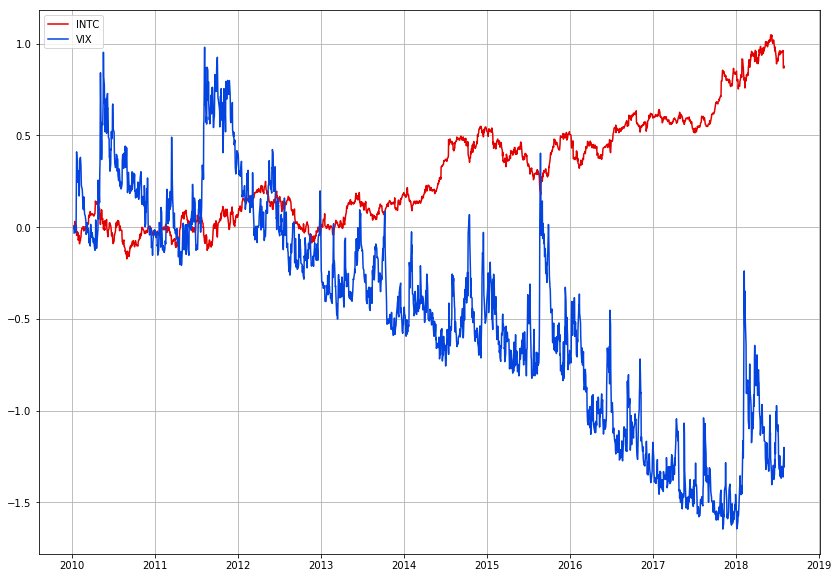

In [31]:
#Plot Cumsum close and vix
from matplotlib.pyplot import figure
figure(num=None, figsize=(14, 10))
plt.plot(np.cumsum(train_data[['Close_logReturns']]), color='xkcd:red',linestyle ='-')
plt.plot(np.cumsum(train_data[['VIX_logReturns']]),color='xkcd:blue',linestyle ='-')
plt.grid(True,which ='both')
plt.legend(['INTC','VIX'], loc='upper left')

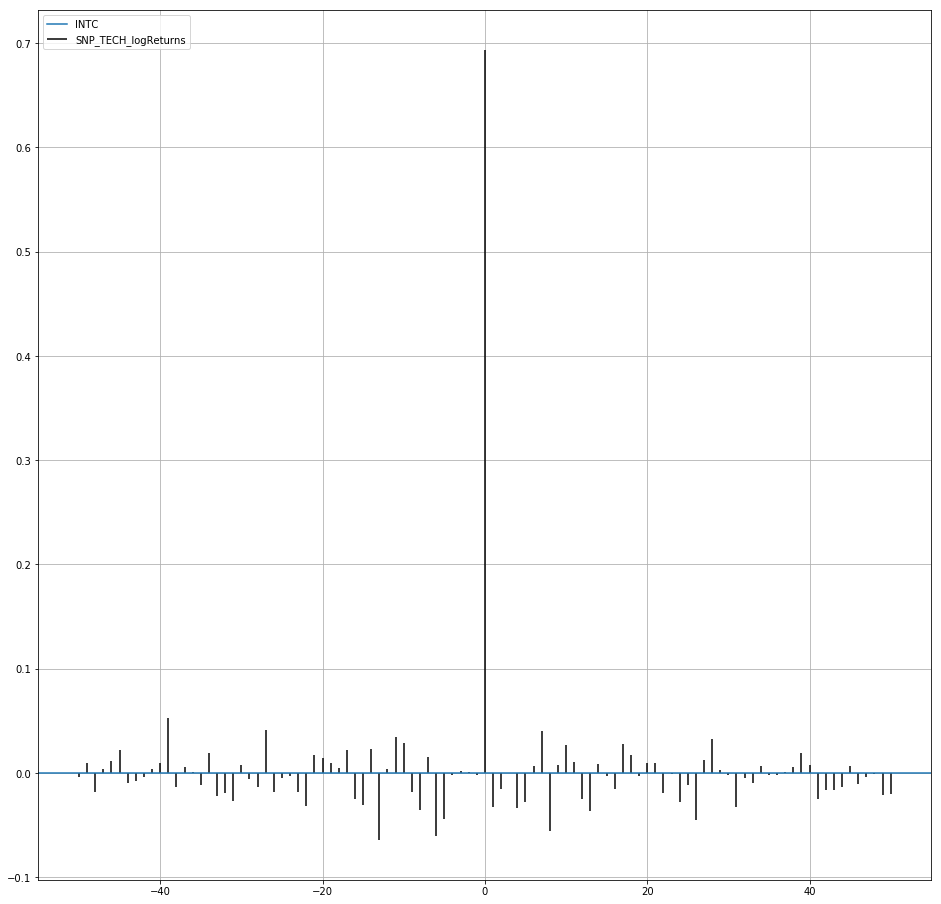

In [32]:
# show lagged cross correlation between intc and highest corr coeff
import matplotlib.pyplot as plt
intc_arr = np.array((df_corr2[['Close_logReturns']]))
snptech_arr = np.array((df_corr2[['SNP_TECH_logReturns']]))
intc_arr = intc_arr.ravel()
snptech_arr = snptech_arr.ravel()
plt.rc("figure",figsize=(16,16))
plt.xcorr(intc_arr,snptech_arr,maxlags=50, usevlines=1)
plt.grid(True)
plt.legend(['INTC','SNP_TECH_logReturns'], loc='upper left')
plt.show()

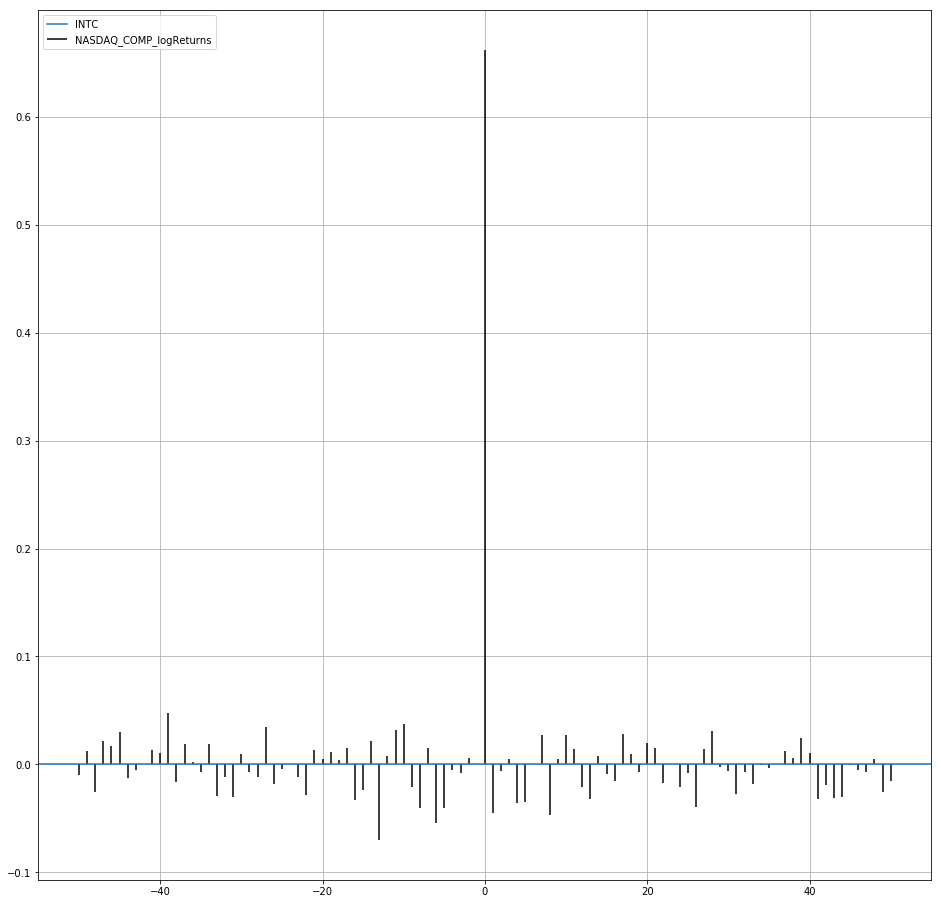

In [33]:
# show lagged cross correlation with NASDAQ_COMP
intc_arr = np.array((df_corr2[['Close_logReturns']]))
snptech_arr = np.array((df_corr2[['NASDAQ_COMP_logReturns']]))
intc_arr = intc_arr.ravel()
snptech_arr = snptech_arr.ravel()
plt.rc("figure",figsize=(16,16))
plt.xcorr(intc_arr,snptech_arr,maxlags=50, usevlines=1)
plt.grid(True)
plt.legend(['INTC','NASDAQ_COMP_logReturns'], loc='upper left')
plt.show()

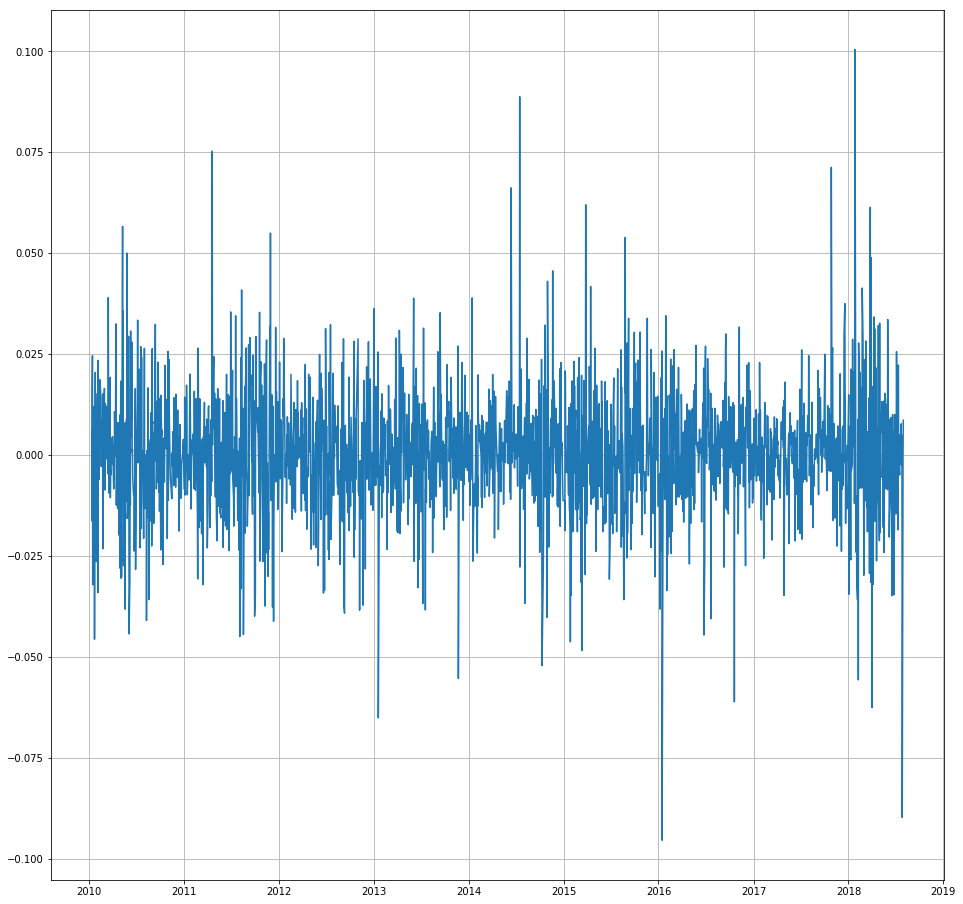

In [34]:
# Show distribution of log returns of INTC
plt.rc("figure",figsize=(16,16))
plt.plot(train_data[['Close_logReturns']])
plt.grid(True)

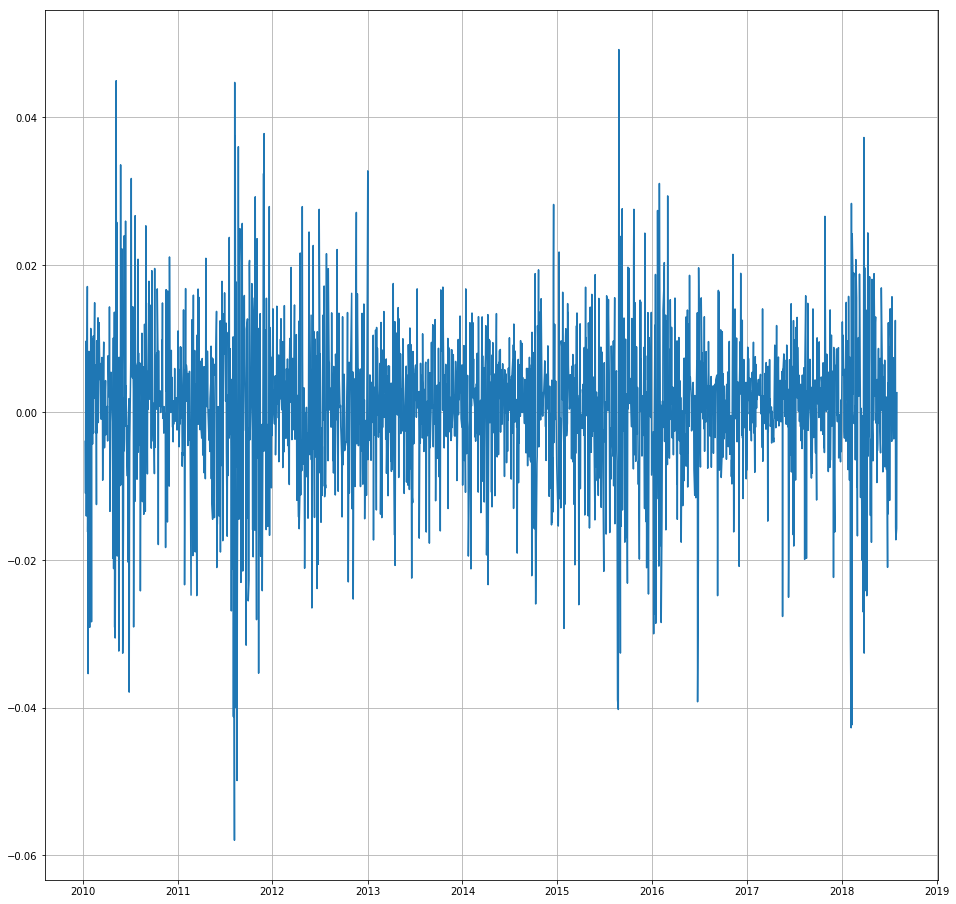

In [35]:
# Show distribution of log returns of SNP Tech
plt.rc("figure",figsize=(16,16))
plt.plot(train_data[['SNP_TECH_logReturns']])
plt.grid(True)

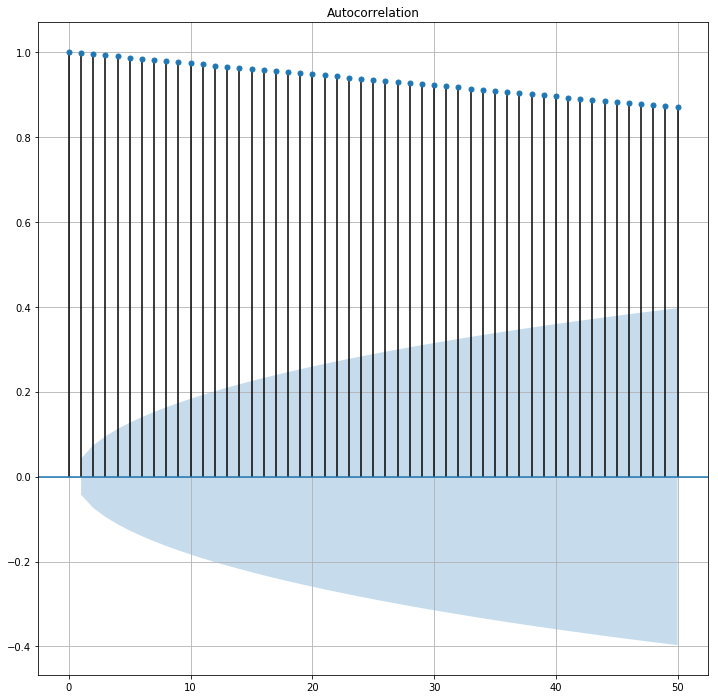

In [36]:
# plot auto correlation with itself
from statsmodels.graphics.tsaplots import plot_acf
intc_arr = np.array(np.cumsum(train_data[['Close_logReturns']]))
intc_arr = intc_arr.ravel()
series = intc_arr
plt.rc("figure",figsize=(12,12))
plot_acf(series, lags=50,use_vlines=True)
plt.grid(True)

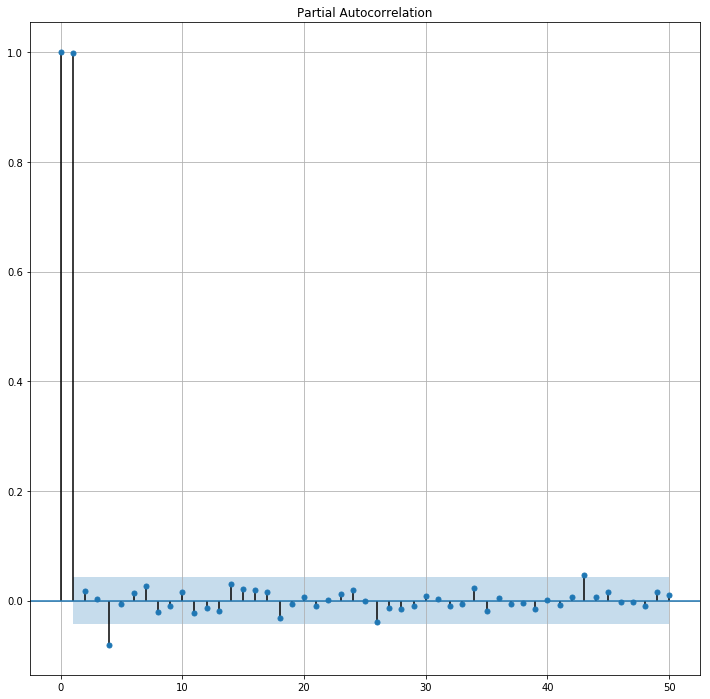

In [37]:
# plot partial auto correlation of INTC
from statsmodels.graphics.tsaplots import plot_pacf
plt.rc("figure",figsize=(12,12))
plot_pacf(series, lags=50,use_vlines=True)
plt.grid(True)

In [38]:
train_data

Weekday  Daymonth  Month  Weakyear  High_logReturns  \
Date                                                              
2010-01-11        0        11      1         2         0.012369   
2010-01-12        1        12      1         2        -0.011891   
2010-01-13        2        13      1         2         0.008576   
2010-01-14        3        14      1         2         0.022051   
2010-01-15        4        15      1         2        -0.006985   
2010-01-19        1        19      1         3        -0.010806   
2010-01-20        2        20      1         3        -0.001418   
2010-01-21        3        21      1         3         0.008009   
2010-01-22        4        22      1         3        -0.024704   
2010-01-25        0        25      1         4        -0.010152   
2010-01-26        1        26      1         4        -0.009766   
2010-01-27        2        27      1         4        -0.002456   
2010-01-28        3        28      1         4         0.002947   
2010-01-29        4        29      1         4        -0.007878   
2010-02-01        0         1      2         5        -0.024013   
2010-02-02        1         2      2         5         0.014577   
2010-02-03        2         3      2         5        -0.008016   
2010-02-04        3         4      2         5        -0.015206   
2010-02-05        4         5      2         5         0.000000   
2010-02-08        0         8      2         6         0.010668   
2010-02-09        1         9      2         6         0.005040   
2010-02-10        2        10      2         6        -0.001006   
2010-02-11        3        11      2         6         0.016472   
2010-02-12        4        12      2         6         0.023484   
2010-02-16        1        16      2         7         0.008187   
2010-02-17        2        17      2         7         0.000480   
2010-02-18        3        18      2         7        -0.000480   
2010-02-19        4        19      2         7         0.005739   
2010-02-22        0        22      2         8        -0.000477   
2010-02-23        1        23      2         8        -0.000477   
...             ...       ...    ...       ...              ...   
2018-06-19        1        19      6        25        -0.025176   
2018-06-20        2        20      6        25         0.014996   
2018-06-21        3        21      6        25         0.014407   
2018-06-22        4        22      6        25        -0.026762   
2018-06-25        0        25      6        26        -0.025564   
2018-06-26        1        26      6        26        -0.026235   
2018-06-27        2        27      6        26        -0.006967   
2018-06-28        3        28      6        26        -0.011452   
2018-06-29        4        29      6        26         0.012450   
2018-07-02        0         2      7        27         0.003188   
2018-07-03        1         3      7        27         0.011668   
2018-07-05        3         5      7        27         0.001964   
2018-07-06        4         6      7        27         0.010541   
2018-07-09        0         9      7        28         0.007544   
2018-07-10        1        10      7        28         0.007105   
2018-07-11        2        11      7        28        -0.007491   
2018-07-12        3        12      7        28         0.011692   
2018-07-13        4        13      7        28        -0.001144   
2018-07-16        0        16      7        29        -0.001909   
2018-07-17        1        17      7        29        -0.008445   
2018-07-18        2        18      7        29         0.001733   
2018-07-19        3        19      7        29         0.000769   
2018-07-20        4        20      7        29         0.001153   
2018-07-23        0        23      7        30         0.008224   
2018-07-24        1        24      7        30         0.015123   
2018-07-25        2        25      7        30        -0.016076   
2018-07-26        3        26      7        30         0.01

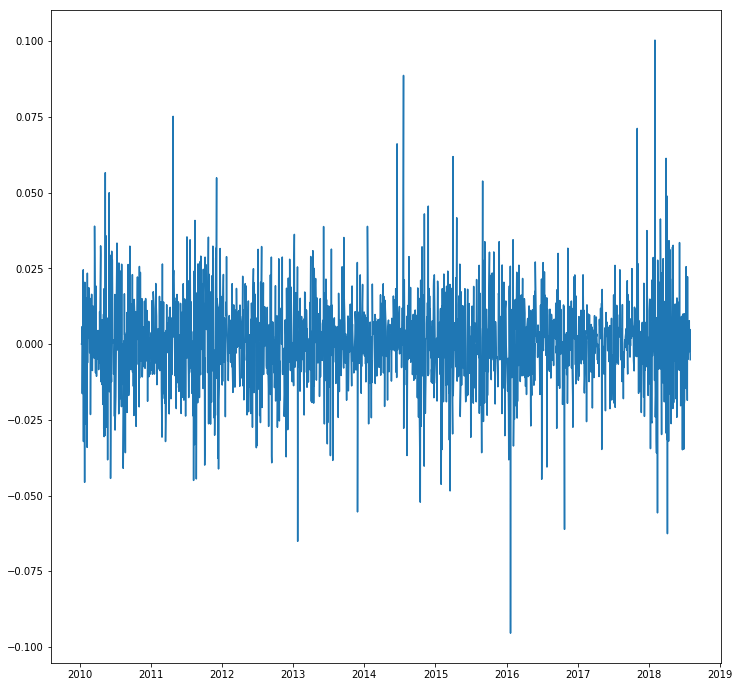

In [39]:
plt.plot(train_data['Target'])

In [40]:
# clip data and cut extremes
train_data['Target'] = train_data['Target'].clip(-0.05,0.05)

In [41]:
train_data_dropped = train_data.drop(['High_logReturns','Low_logReturns','Close_logReturns','AMZN_logReturns','NVDA_logReturns',
                             'GOOG_logReturns','NFLX_logReturns','EUROSTOXX50_logReturns',
                             'SNP500_logReturns','CONS_DESCRETE_logReturns','yield_5y_logReturns','Tnote_10y_logReturns'
                             ], axis=1)

y = train_data_dropped['Target']

# drop target variable from dataframe
train_data_final = train_data_dropped.drop(['Target'], axis=1)

# Train and test on ExtraTrees
X_train, X_test, y_train, y_test = ms.train_test_split(train_data_final, y, test_size=0.3)


# Correlation between feature and target

In [42]:
features = train_data_final.columns.tolist()
target = y.name

correlations = {}
for f in features:
    data_temp = train_data_dropped[[f,target]]
    x1 = data_temp[f].values
    x2 = data_temp[target].values
    key = f + ' vs ' + target
    correlations[key] = pearsonr(x1,x2)[0]
    
data_correlations = pd.DataFrame(correlations, index=['Value']).T
data_correlations.loc[data_correlations['Value'].abs().sort_values(ascending=False).index]

Value
TSI_Scaled vs Target                  0.061807
support_distance_Scaled vs Target     0.043099
Weekday vs Target                     0.037280
Month vs Target                       0.030100
Weakyear vs Target                    0.026085
MSFT_logReturns vs Target             0.024948
Daymonth vs Target                   -0.013531
OBV_Scaled vs Target                  0.013366
NASDAQ_COMP_logReturns vs Target     -0.011300
resistance_distance_Scaled vs Target -0.009425
VIX_logReturns vs Target              0.007449
TradingRange_Scaled vs Target        -0.005669
KFMean_Scaled vs Target               0.005275
ATR_Scaled vs Target                 -0.005049
HighestHigh_Scaled vs Target          0.004611
LowestLow_Scaled vs Target            0.002767
Volume_Scaled vs Target              -0.002063
SNP_TECH_logReturns vs Target         0.000385

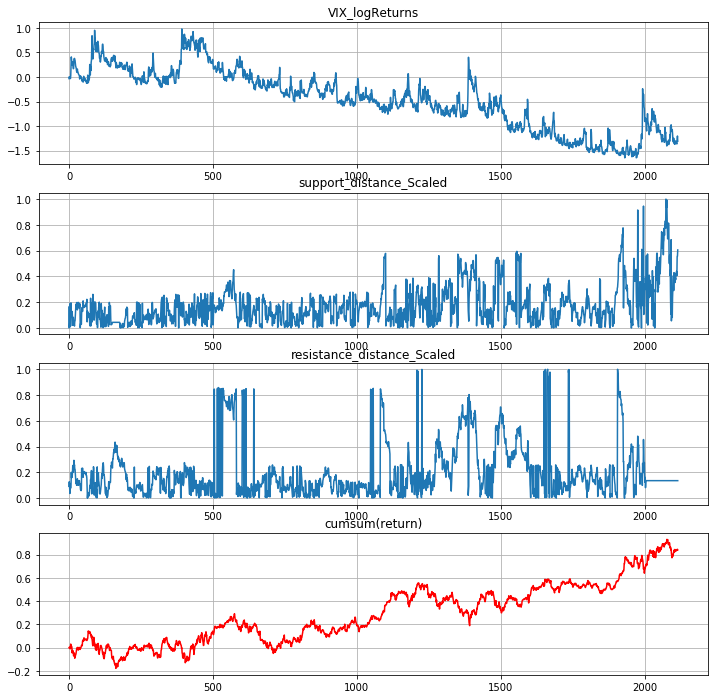

In [43]:
y = train_data_dropped.loc[:,['VIX_logReturns','support_distance_Scaled','resistance_distance_Scaled',target]].values
x = np.arange(y.shape[0])

%matplotlib inline
plt.rc("figure",figsize=(12,12))
plt.subplot(4,1,1)
plt.plot(x,np.cumsum(y[:,0]))
plt.title('VIX_logReturns')
plt.grid(True)
plt.ylabel('')

plt.subplot(4,1,2)
plt.plot(x,(y[:,1]))
plt.title('support_distance_Scaled')
plt.grid(True)
plt.ylabel('')

plt.subplot(4,1,3)
plt.plot(x,(y[:,2]))
plt.title('resistance_distance_Scaled')
plt.grid(True)
plt.ylabel('')

plt.subplot(4,1,4)
plt.plot(x,np.cumsum(y[:,3]),'r')
plt.title('cumsum(return)')
plt.ylabel("")
plt.grid(True)
plt.show()

# train xgboost linear regression

In [44]:
from sklearn.model_selection import RandomizedSearchCV

xgb = xgboost.XGBRegressor()
# Learning rate in tree
learning_rate = [x/1000 for x in np.linspace(11, 310, num = 50)] 

# Number of trees in random forest
n_estimators = range(10,350,10)
# Maximum number of levels in tree
max_depth = range(3,12,2)
# A smaller value should be chosen because it is a highly imbalanced 
# class problem and leaf nodes can have smaller size groups.
min_child_weight = range(2,20,2)
# Method of selecting samples for training each tree
subsample = [i/10.0 for i in range(6,10)]

colsample_bytree = [i/10.0 for i in range(4,10)]

reg_alpha = [0.0001, 0.001, 0.1, 1, 100]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_depth': max_depth,
               'min_child_weight': min_child_weight,
               'subsample': subsample,
               'colsample_bytree': colsample_bytree,
               'reg_alpha' : reg_alpha
              }
xgb_model = RandomizedSearchCV(
    estimator = xgb, 
    param_distributions = random_grid, 
    n_iter = 100, 
    cv = 5, 
    verbose=1, 
    random_state=1001)

xgb_model.fit(X_train, y_train)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  2.2min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid=True, n_iter=100, n_jobs=1,
          param_distributions={'n_estimators': range(10, 350, 10), 'learning_rate': [0.011, 0.01710204081632653, 0.02320408163265306, 0.029306122448979594, 0.035408163265306124, 0.041510204081632654, 0.047612244897959184, 0.053714285714285714, 0.059816326530612245, 0.06591836734693876, 0.0720204081632653, 0.0...0.9], 'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'reg_alpha': [0.0001, 0.001, 0.1, 1, 100]},
          pre_dispatch='2*n_jobs', random_state=1001, refit=True,
          r

In [45]:
xgb_model.best_params_

{'subsample': 0.7,
 'reg_alpha': 1,
 'n_estimators': 320,
 'min_child_weight': 18,
 'max_depth': 7,
 'learning_rate': 0.22457142857142856,
 'colsample_bytree': 0.4}

In [46]:
xgb_model.cv_results_['mean_train_score']
#xgb_model.cv_results_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


array([ 7.79084895e-01,  9.59706443e-01,  4.58768989e-02,  7.96980435e-01,
       -4.19007272e+02,  5.16925747e-01,  5.75521644e-01, -4.31838946e+01,
        5.71798558e-02,  5.01164917e-02,  4.75229704e-02, -7.47541665e+01,
        9.96993941e-01,  9.98279859e-01,  8.86548126e-01,  7.38499652e-01,
        8.89319340e-01,  5.62486266e-01,  7.30728769e-01,  3.95872122e-01,
        9.47002429e-01,  4.35531552e-02,  1.17807714e-02,  5.49554613e-02,
        8.18217304e-01,  2.69693967e-01,  2.47063170e-01, -7.15198269e+01,
        3.69187988e-02,  3.82532970e-01,  4.38168993e-01,  6.47073812e-01,
        6.96692689e-01,  5.95230868e-02,  9.88429094e-01, -9.37988032e+01,
        3.46804407e-02, -6.94416481e+01, -5.31747279e+01,  5.18115205e-02,
        4.89631010e-02, -6.97672262e+01,  8.86404419e-01,  6.99292197e-01,
        9.01221747e-01,  6.77957783e-01,  3.00964225e-01, -2.17834754e+02,
        9.64412330e-01,  9.60502868e-01,  5.31112540e-02, -2.61031755e+00,
        5.66462016e-02,  

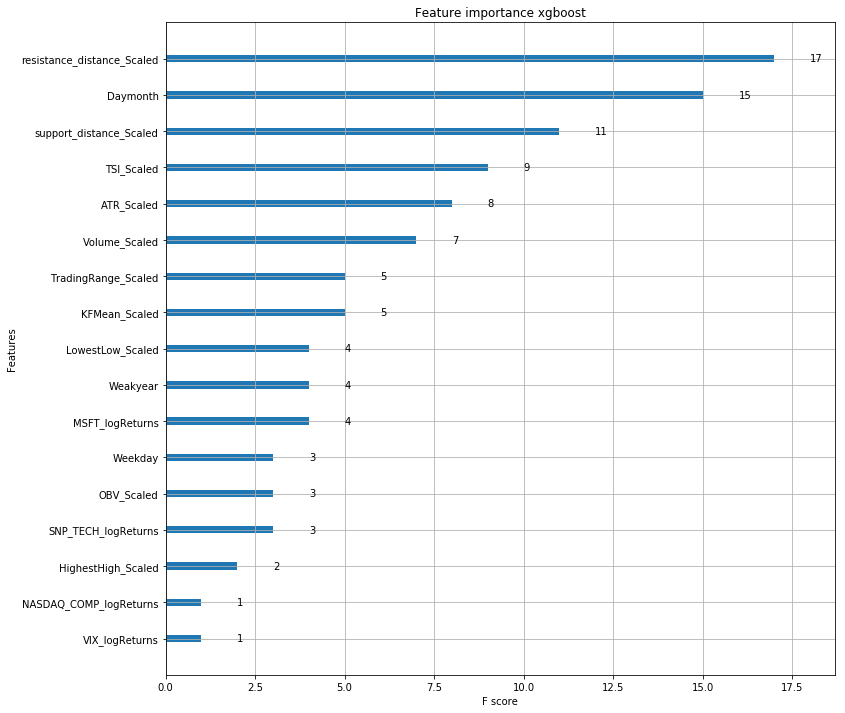

In [47]:
xgb = xgboost.XGBRegressor(**xgb_model.best_params_)
xgb.fit(X_train, y_train)
from xgboost import plot_importance
# plot feature importance
plt.rc("figure",figsize=(12,12))
plot_importance(xgb)
plt.title("Feature importance xgboost")
plt.show()

Coefficient of determination on training set: (R^2) 0.03157572908426509
Average coefficient of determination using 5-fold crossvalidation: -0.013953907057633575


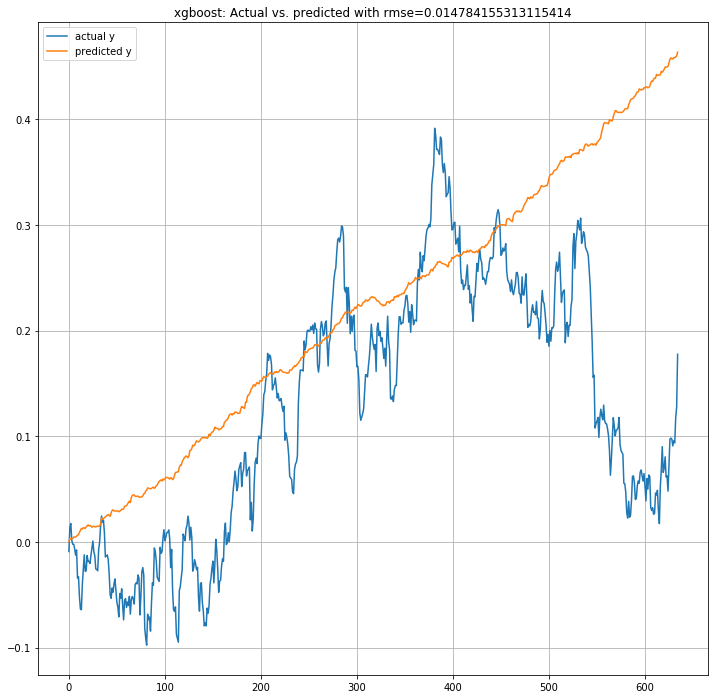

In [48]:
print ("Coefficient of determination on training set: (R^2)",xgb.score(X_train, y_train))
cv = KFold(X_train.shape[0], 5, shuffle=True, random_state=33)
scores = cross_val_score(xgb, X_train, y_train, cv=cv)
print ("Average coefficient of determination using 5-fold crossvalidation:",np.mean(scores))

predicted_values = xgb.predict(X_test)
actual_and_test = np.column_stack([y_test, predicted_values])

rms = sqrt(mean_squared_error(actual_and_test[:,0], actual_and_test[:,1]))
rms = sqrt(mean_squared_error(actual_and_test[:,0], actual_and_test[:,1]))

plt.title("xgboost: Actual vs. predicted with rmse=" + str(rms) + "")
plt.rc("figure",figsize=(15,15))
plt.plot(np.cumsum(actual_and_test[:,0]))
plt.plot(np.cumsum(actual_and_test[:,1]))
plt.legend(['actual y', 'predicted y'])
plt.grid(True)

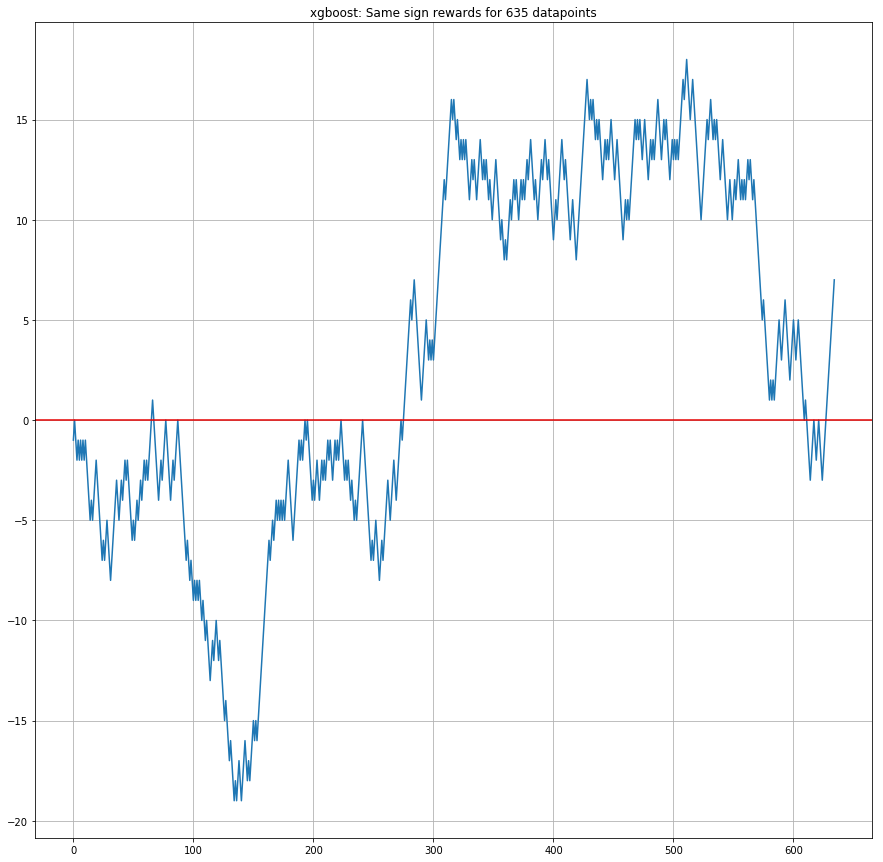

In [49]:
sign = [] 
for i in range(len(actual_and_test)):         
    if np.sign(actual_and_test[i,0]) == np.sign(actual_and_test[i,1]):
        sign.append(1)
    else:
        sign.append(-1)
res = np.column_stack([actual_and_test,sign])
plt.plot(np.cumsum(sign))
plt.axhline(y=0,color='xkcd:red',linestyle ='-')
plt.title("xgboost: Same sign rewards for " + str(len(sign)) +" datapoints")
plt.grid(True)

# Extra Trees regressor

In [50]:

# Fit estimators
model_et  = ExtraTreesRegressor()

from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 250, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 7, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4, 5]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rf_random = RandomizedSearchCV(
    estimator = model_et, 
    param_distributions = random_grid, 
    n_iter = 100, 
    cv = 5, 
    verbose=1, 
    random_state=42, 
    n_jobs = -1)

rf_random.fit(X_train, y_train)

print ("Coefficient of determination on training set: (R^2)",rf_random.score(X_train, y_train))
cv = KFold(X_train.shape[0], 5, shuffle=True, random_state=33)
scores = cross_val_score(rf_random, X_train, y_train, cv=cv)
print ("Average coefficient of determination using 5-fold crossvalidation:",np.mean(scores))


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.4min finished


Coefficient of determination on training set: (R^2) 0.2100709096569643
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.2min finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.1min finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.2min finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.2min finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.3min finished


Average coefficient of determination using 5-fold crossvalidation: -0.015837437872299097


In [51]:
predicted_values = rf_random.predict(X_test)
actual_and_test = np.column_stack([y_test, predicted_values])

In [52]:
rf_random.best_params_

{'n_estimators': 143,
 'min_samples_split': 7,
 'min_samples_leaf': 5,
 'max_features': 'sqrt',
 'max_depth': 60,
 'bootstrap': True}

Feature ranking:
1. feature 1 - Weekday (0.076001)
2. feature 0 - Daymonth (0.070370)
3. feature 9 - Month (0.065370)
4. feature 3 - Weakyear (0.065333)
5. feature 2 - MSFT_logReturns (0.063563)
6. feature 16 - SNP_TECH_logReturns (0.057875)
7. feature 11 - NASDAQ_COMP_logReturns (0.055100)
8. feature 13 - VIX_logReturns (0.054896)
9. feature 12 - Volume_Scaled (0.054623)
10. feature 14 - ATR_Scaled (0.052966)
11. feature 17 - TSI_Scaled (0.052039)
12. feature 6 - OBV_Scaled (0.051643)
13. feature 10 - TradingRange_Scaled (0.051326)
14. feature 15 - HighestHigh_Scaled (0.049723)
15. feature 7 - LowestLow_Scaled (0.047758)
16. feature 5 - KFMean_Scaled (0.047012)
17. feature 8 - support_distance_Scaled (0.045907)
18. feature 4 - resistance_distance_Scaled (0.038496)


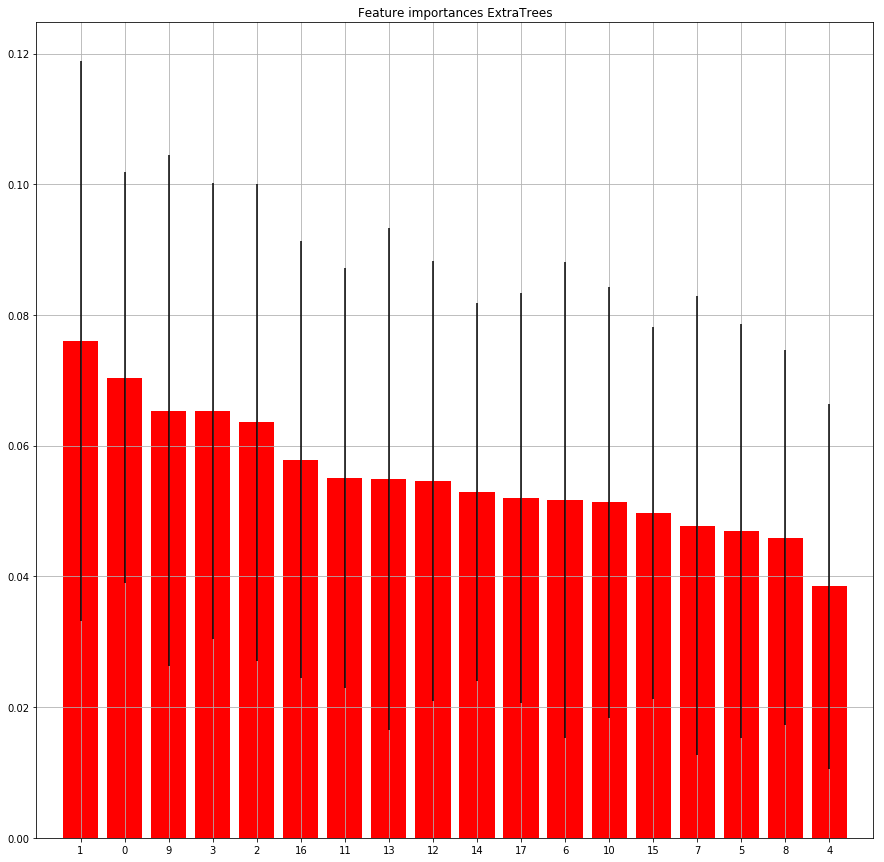

In [53]:
# Show importance of features
importances = rf_random.best_estimator_.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_random.best_estimator_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d - %s (%f)" % (f + 1, indices[f],X_train.columns[f], importances[indices[f]]))
    
    
# Plot the feature importances of the forest
plt.rc("figure",figsize=(15,15))
plt.figure()
plt.title("Feature importances ExtraTrees")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.grid(True)
plt.show()


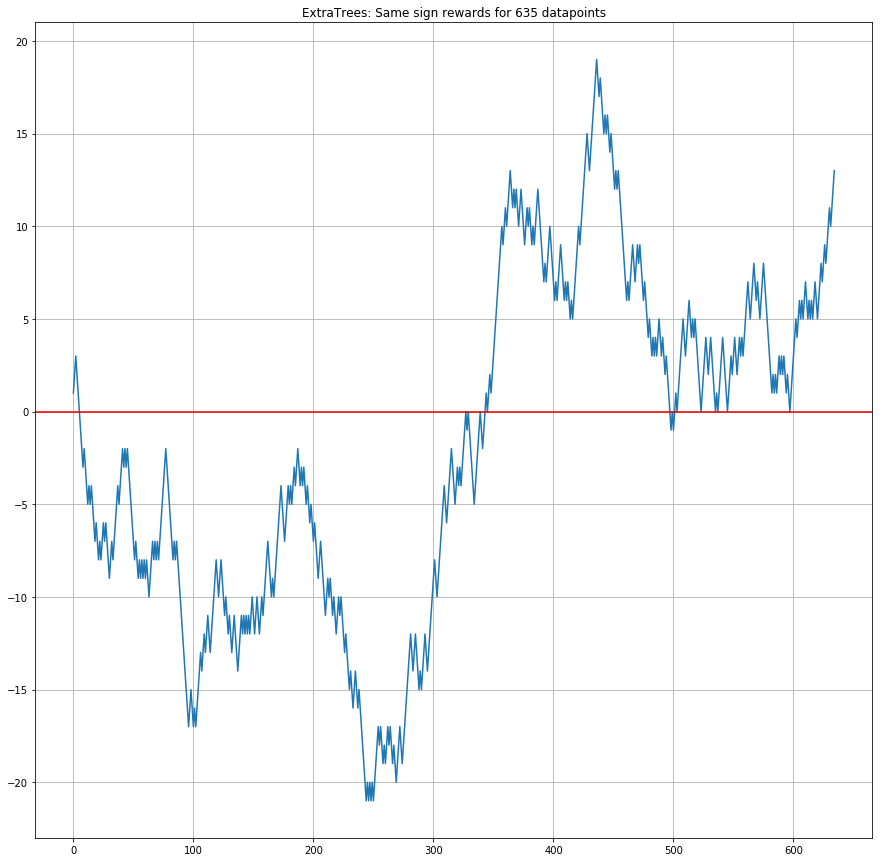

In [54]:
sign = [] 
for i in range(len(actual_and_test)):         
    if np.sign(actual_and_test[i,0]) == np.sign(actual_and_test[i,1]):
        sign.append(1)
    else:
        sign.append(-1)
res = np.column_stack([actual_and_test,sign])
plt.plot(np.cumsum(sign))
plt.axhline(y=0,color='xkcd:red',linestyle ='-')
plt.title("ExtraTrees: Same sign rewards for " + str(len(sign)) +" datapoints")
plt.grid(True)

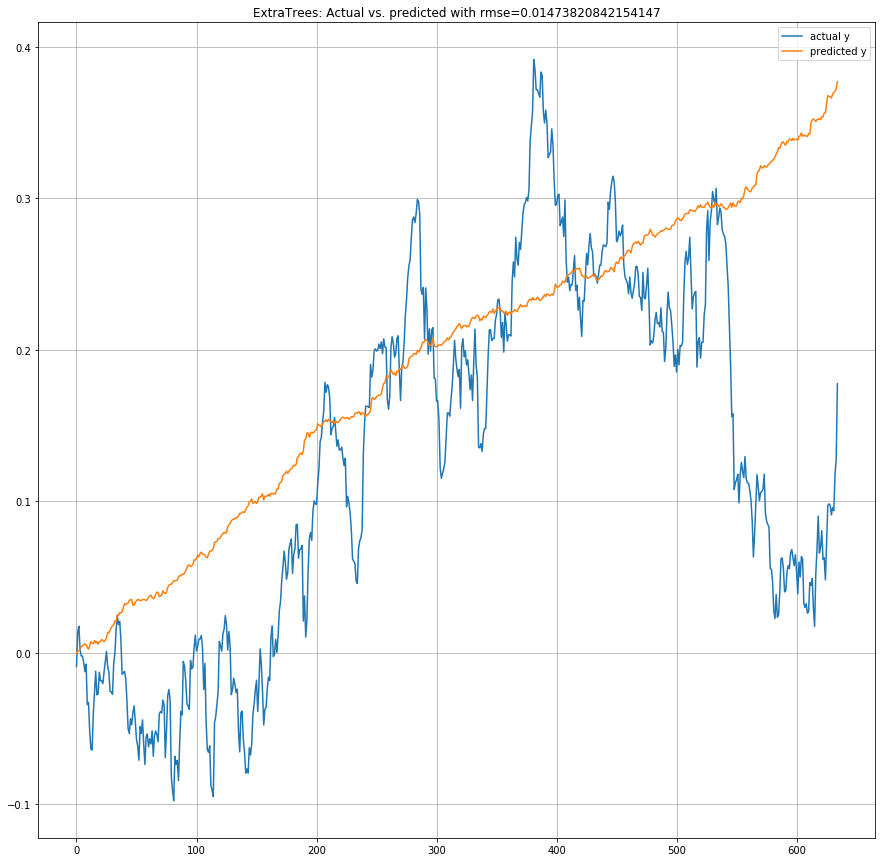

In [55]:
rms = sqrt(mean_squared_error(actual_and_test[:,0], actual_and_test[:,1]))

plt.title("ExtraTrees: Actual vs. predicted with rmse=" + str(rms))
plt.rc("figure",figsize=(15,15))
plt.plot(np.cumsum(actual_and_test[:,0]))
plt.plot(np.cumsum(actual_and_test[:,1]))
plt.legend(['actual y', 'predicted y'])
plt.grid(True)

In [56]:
lr = linear_model.LinearRegression(n_jobs=-1)
lr.fit(X_train, y_train)
predicted_values = lr.predict(X_test)
actual_and_test = np.column_stack([y_test, predicted_values])

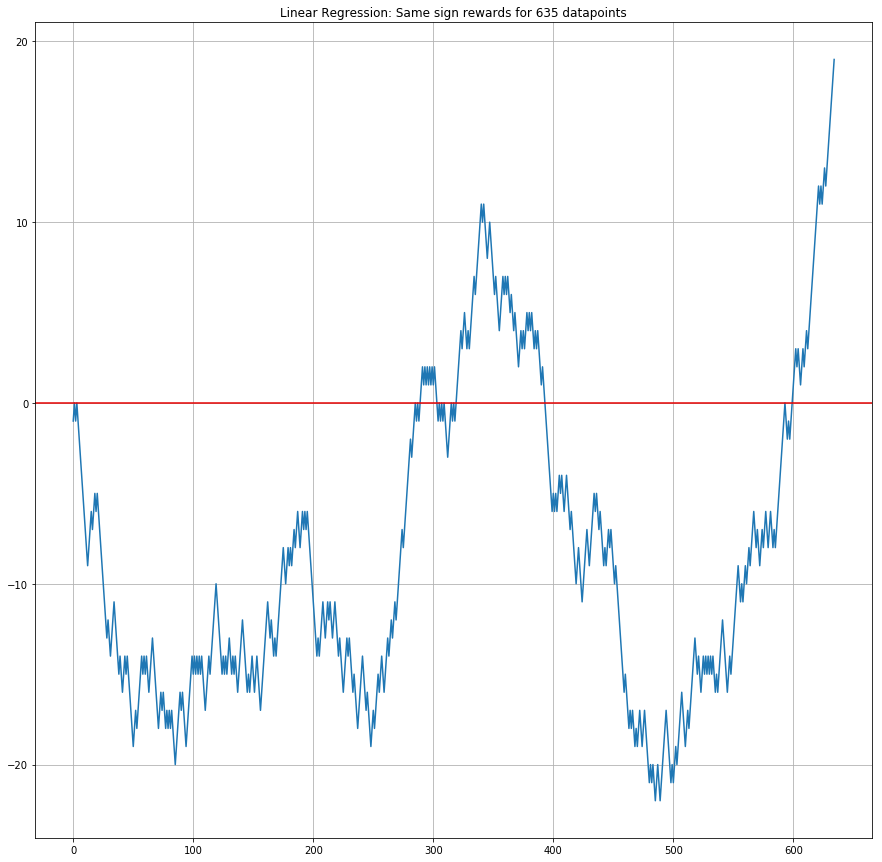

In [57]:
sign = [] 
for i in range(len(actual_and_test)):         
    if np.sign(actual_and_test[i,0]) == np.sign(actual_and_test[i,1]):
        sign.append(1)
    else:
        sign.append(-1)
res = np.column_stack([actual_and_test,sign])
plt.rc("figure",figsize=(15,15))
plt.plot(np.cumsum(sign))
plt.axhline(y=0,color='xkcd:red',linestyle ='-')
plt.title("Linear Regression: Same sign rewards for " + str(len(sign)) +" datapoints")
plt.grid(True)

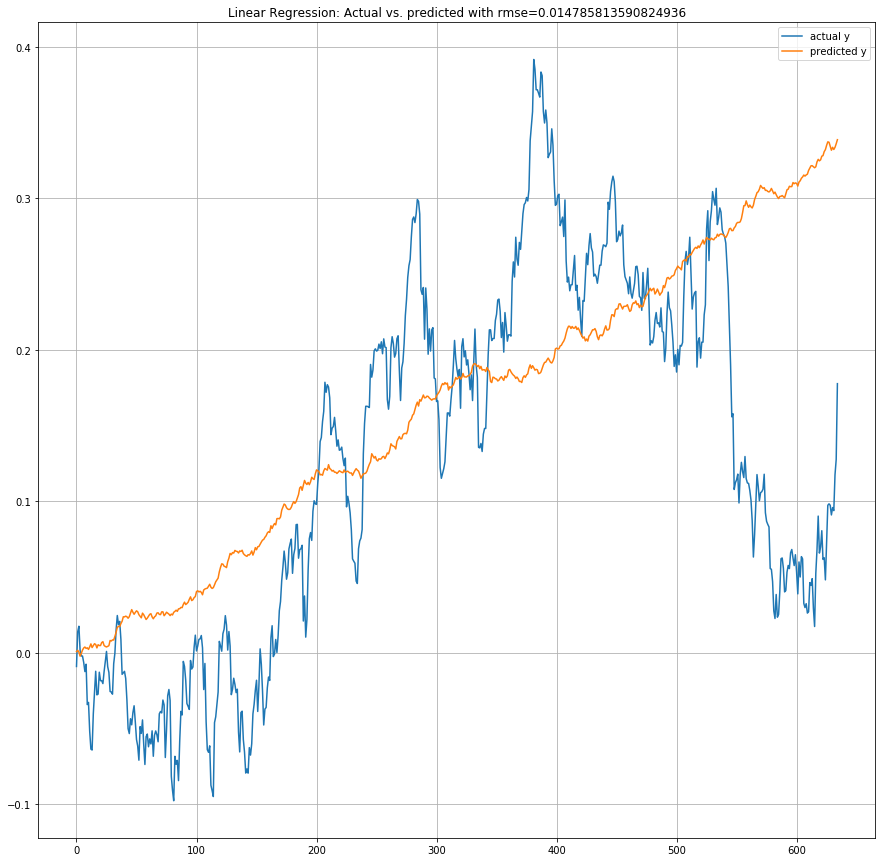

In [58]:
rms = sqrt(mean_squared_error(actual_and_test[:,0], actual_and_test[:,1]))

plt.title("Linear Regression: Actual vs. predicted with rmse=" + str(rms))
plt.rc("figure",figsize=(15,15))
plt.plot(np.cumsum(actual_and_test[:,0]))
plt.plot(np.cumsum(actual_and_test[:,1]))
plt.legend(['actual y', 'predicted y'])
plt.grid(True)

In [59]:
ridge = linear_model.Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
predicted_values = ridge.predict(X_test)
actual_and_test = np.column_stack([y_test, predicted_values])

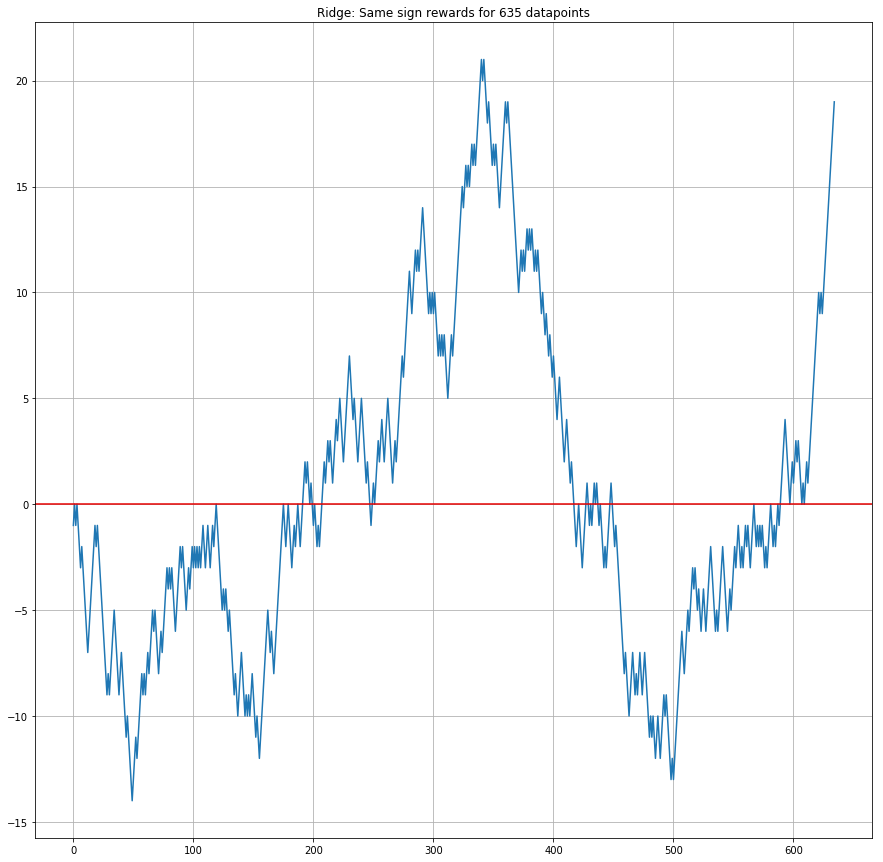

In [60]:
sign = [] 
for i in range(len(actual_and_test)):         
    if np.sign(actual_and_test[i,0]) == np.sign(actual_and_test[i,1]):
        sign.append(1)
    else:
        sign.append(-1)
res = np.column_stack([actual_and_test,sign])
plt.rc("figure",figsize=(15,15))
plt.plot(np.cumsum(sign))
plt.axhline(y=0,color='xkcd:red',linestyle ='-')
plt.title("Ridge: Same sign rewards for " + str(len(sign)) +" datapoints")
plt.grid(True)

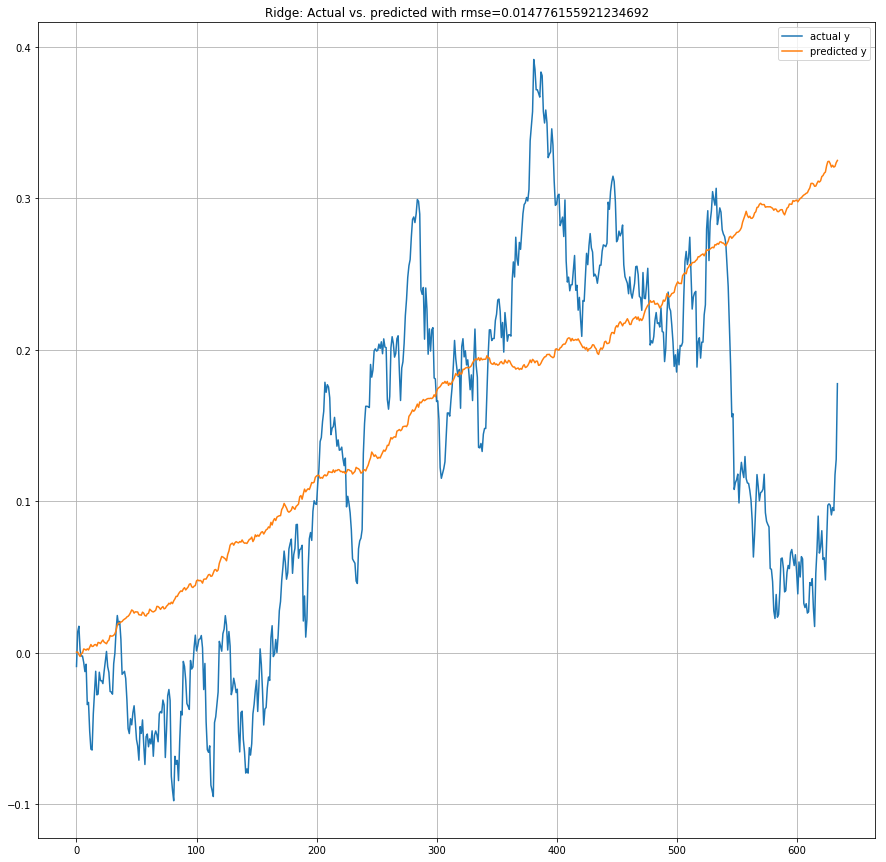

In [61]:
rms = sqrt(mean_squared_error(actual_and_test[:,0], actual_and_test[:,1]))

plt.title("Ridge: Actual vs. predicted with rmse=" + str(rms))
plt.rc("figure",figsize=(15,15))
plt.plot(np.cumsum(actual_and_test[:,0]))
plt.plot(np.cumsum(actual_and_test[:,1]))
plt.legend(['actual y', 'predicted y'])
plt.grid(True)

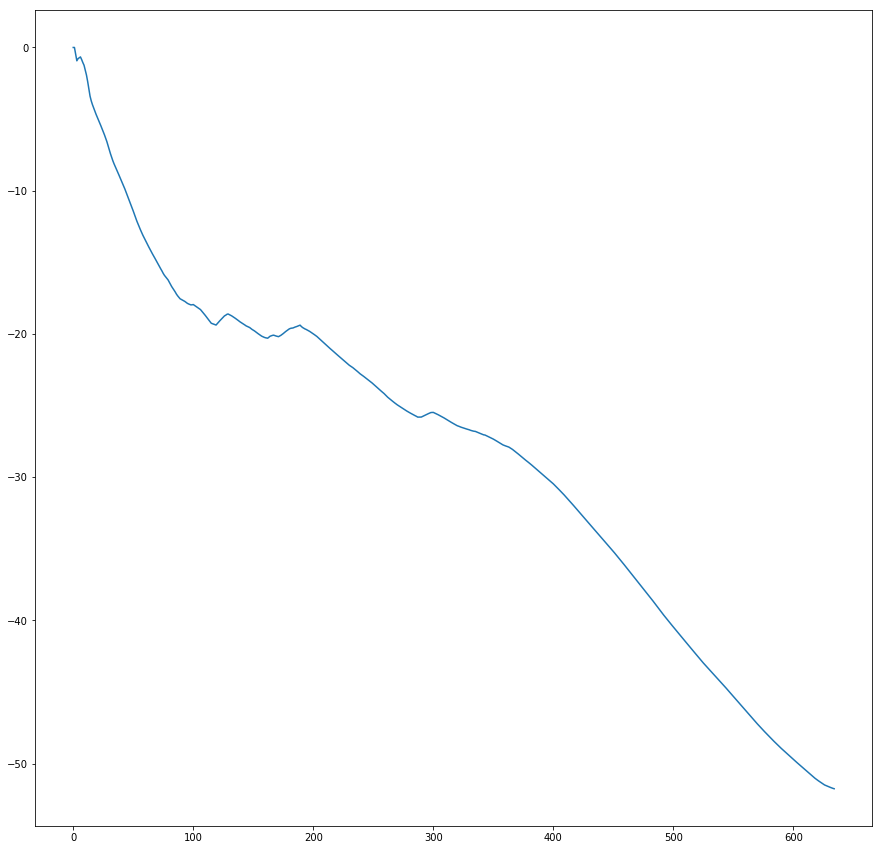

In [62]:
plt.plot(np.cumsum(calc_r_score(actual_and_test)))